# Understanding Hired Rides in NYC

_[Project prompt](https://docs.google.com/document/d/1VERPjEZcC1XSs4-02aM-DbkNr_yaJVbFjLJxaYQswqA/edit#)_

_This scaffolding notebook may be used to help setup your final project. It's **totally optional** whether you make use of this or not._

_If you do use this notebook, everything provided is optional as well - you may remove or add prose and code as you wish._

_Anything in italics (prose) or comments (in code) is meant to provide you with guidance. **Remove the italic lines and provided comments** before submitting the project, if you choose to use this scaffolding. We don't need the guidance when grading._

_**All code below should be consider "pseudo-code" - not functional by itself, and only a suggestion at the approach.**_

## Project Setup

In [149]:
# all import statements needed for the project, for example:

import os
import time
import bs4
import re
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import requests
import sqlalchemy as db
import math
from pyproj import CRS, Transformer
from sqlalchemy import create_engine, Table, Column, Integer, Float, String, DateTime, MetaData
import sqlite3
from typing import List
import folium
from folium.plugins import HeatMap

In [4]:
TLC_URL = "https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page"

TAXI_ZONES_DIR = ""
TAXI_ZONES_SHAPEFILE = f"{TAXI_ZONES_DIR}/taxi_zones.shp"
WEATHER_CSV_DIR = ""

CRS = 4326  # coordinate reference system

# (lat, lon)
NEW_YORK_BOX_COORDS = ((40.560445, -74.242330), (40.908524, -73.717047))
LGA_BOX_COORDS = ((40.763589, -73.891745), (40.778865, -73.854838))
JFK_BOX_COORDS = ((40.639263, -73.795642), (40.651376, -73.766264))
EWR_BOX_COORDS = ((40.686794, -74.194028), (40.699680, -74.165205))

#DATABASE_URL = "C:/Final_Project_Dataset/database"
DATABASE_SCHEMA_FILE = "schema.sql"
QUERY_DIRECTORY = "queries"

In [6]:
# Make sure the QUERY_DIRECTORY exists
try:
    os.mkdir(QUERY_DIRECTORY)
except Exception as e:
    if e.errno == 17:
        # the directory already exists
        pass
    else:
        raise

### We first get all the URLs for the datasets we want from the website and download them. ###

In [5]:
# Function to fetch webpage content
def fetch_webpage(url：str) -> str:
    """
    Fetches the content of a webpage given its URL.

    Parameters:
    url (str): The URL of the webpage to fetch.

    Returns:
    str: The HTML content of the webpage if the request is successful.

    Raises:
    Exception: If the request fails, an exception is raised with the status code.
    """
    response = requests.get(url)
    if response.status_code == 200:
        return response.text
    else:
        raise Exception(f"Failed to fetch webpage. Status code: {response.status_code}")

# Function for downloading the files
def download_file(link: str, destination_folder: str) -> None:
    """
    Downloads a single file from a given URL and saves it to a specified folder.

    Parameters:
    link (str): The URL of the file to be downloaded.
    destination_folder (str): The folder where the downloaded file will be saved.

    Returns:
    None

    Side Effects:
    - Creates the destination folder if it does not already exist.
    - Saves the downloaded file in the specified folder.
    - Prints the status of the download (success or failure).

    Notes:
    - If the download fails, an error message with the status code is printed.
    - The file is saved with its original name as derived from the URL.
    """
    response = requests.get(link)
    if response.status_code == 200:
        os.makedirs(destination_folder, exist_ok=True)
        filename = os.path.join(destination_folder, os.path.basename(link))
        with open(filename, "wb") as file:
            file.write(response.content)
        print(f"Downloaded: {filename}")
    else:
        print(f"Failed to download: {link}. Status code: {response.status_code}")

In [7]:
# Fetch webpage content
webpage_content = fetch_webpage(TLC_URL)
soup = BeautifulSoup(webpage_content, "html.parser")
links = [a['href'] for a in soup.find_all('a', href=True)]

# Regular expressions for yellow_tripdata and fhvhv_tripdata
yellow_tripdata_pattern = r'https://.*yellow_tripdata_202[01234].*\.parquet'
fhvhv_tripdata_pattern = r'https://.*fhvhv_tripdata_202[01234].*\.parquet'

# Filter links using the regular expressions
yellow_tripdata_links = [link for link in links if re.match(yellow_tripdata_pattern, link)]
fhvhv_tripdata_links = [link for link in links if re.match(fhvhv_tripdata_pattern, link)]

In [11]:
all_links = yellow_tripdata_links + fhvhv_tripdata_links

# Destination folder to save files
destination_folder = "C:/Final_Project_Dataset"
    
#Download all files
for i in all_links:
    download_file(i, destination_folder)

Failed to download: https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-01.parquet . Status code: 403
Failed to download: https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-02.parquet . Status code: 403
Failed to download: https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-03.parquet . Status code: 403
Downloaded: C:/Final_Project_Dataset\yellow_tripdata_2024-04.parquet
Downloaded: C:/Final_Project_Dataset\yellow_tripdata_2024-05.parquet
Downloaded: C:/Final_Project_Dataset\yellow_tripdata_2024-06.parquet
Downloaded: C:/Final_Project_Dataset\yellow_tripdata_2024-07.parquet
Downloaded: C:/Final_Project_Dataset\yellow_tripdata_2024-08.parquet
Downloaded: C:/Final_Project_Dataset\yellow_tripdata_2024-09.parquet
Downloaded: C:/Final_Project_Dataset\yellow_tripdata_2023-01.parquet
Downloaded: C:/Final_Project_Dataset\yellow_tripdata_2023-02.parquet
Downloaded: C:/Final_Project_Dataset\yellow_tripdata_2023-03.parquet
Downloaded: C:/Final_P

#### There are quite a few links that fail when downloading programmatically. We will download them manually. ####

## Part 1: Data Preprocessing

In [9]:
#Example file 1-High Volume
file1 = 'C:/Final_Project_Dataset/fhvhv_tripdata_2023-02.parquet'
pd1 = pd.read_parquet(file1)
pd1

,hvfhs_license_num,dispatching_base_num,originating_base_num,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,...,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay,shared_request_flag,shared_match_flag,access_a_ride_flag,wav_request_flag,wav_match_flag
0,HV0003,B03404,B03404,2023-02-01 00:12:17,2023-02-01 00:13:34,2023-02-01 00:15:34,2023-02-01 00:25:01,244,74,5.410,...,1.16,0.00,0.0,0.0,12.82,N,N,,N,N
1,HV0003,B03404,B03404,2023-02-01 00:24:45,2023-02-01 00:25:53,2023-02-01 00:26:07,2023-02-01 00:31:47,74,168,1.390,...,0.71,0.00,0.0,0.0,6.57,N,N,,N,N
2,HV0003,B03404,B03404,2023-02-01 00:06:48,2023-02-01 00:08:47,2023-02-01 00:09:57,2023-02-01 00:13:09,36,36,0.600,...,0.67,0.00,0.0,3.0,5.37,N,N,,N,N
3,HV0003,B03404,B03404,2023-02-01 00:14:35,2023-02-01 00:16:31,2023-02-01 00:17:43,2023-02-01 00:37:01,36,7,7.580,...,2.29,0.00,0.0,0.0,20.13,N,N,,N,N
4,HV0003,B03404,B03404,2023-02-01 00:43:28,2023-02-01 00:46:11,2023-02-01 00:47:59,2023-02-01 00:55:36,7,145,1.380,...,0.87,0.00,0.0,1.0,5.97,N,N,,N,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17960966,HV0005,B03406,None,2023-02-28 23:24:30,NaT,2023-02-28 23:31:04,2023-02-28 23:39:28,41,42,1.424,...,0.80,0.00,0.0,0.0,6.49,N,N,N,N,N
17960967,HV0005,B03406,None,2023-02-28 23:39:36,NaT,2023-02-28 23:42:36,2023-02-28 23:50:05,42,168,1.694,...,0.55,0.00,0.0,0.0,6.31,N,N,N,N,N
17960968,HV0003,B03404,B03404,2023-02-28 23:21:30,2023-02-28 23:22:21,2023-02-28 23:23:06,2023-02-28 23:34:37,79,87,3.030,...,1.44,2.75,0.0,0.0,10.72,N,N,,N,N
17960969,HV0003,B03404,B03404,2023-02-28 23:40:06,2023-02-28 23:42:54,2023-02-28 23:43:53,2023-02-28 23:58:03,209,106,3.620,...,1.60,2.75,0.0,0.0,12.93,N,N,,N,N


In [11]:
column_names1 = pd1.columns.tolist()
print(column_names1)

['hvfhs_license_num', 'dispatching_base_num', 'originating_base_num', 'request_datetime', 'on_scene_datetime', 'pickup_datetime', 'dropoff_datetime', 'PULocationID', 'DOLocationID', 'trip_miles', 'trip_time', 'base_passenger_fare', 'tolls', 'bcf', 'sales_tax', 'congestion_surcharge', 'airport_fee', 'tips', 'driver_pay', 'shared_request_flag', 'shared_match_flag', 'access_a_ride_flag', 'wav_request_flag', 'wav_match_flag']


In [13]:
#Example file 2-Yellow Taxi
file2 = 'C:/Final_Project_Dataset/yellow_tripdata_2023-09.parquet'
pd2 = pd.read_parquet(file2)
pd2

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,1,2023-09-01 00:15:37,2023-09-01 00:20:21,1.0,0.80,1.0,N,163,230,2,6.50,3.5,0.5,0.00,0.0,1.0,11.50,2.5,0.00
1,2,2023-09-01 00:18:40,2023-09-01 00:30:28,2.0,2.34,1.0,N,236,233,1,14.20,1.0,0.5,2.00,0.0,1.0,21.20,2.5,0.00
2,2,2023-09-01 00:35:01,2023-09-01 00:39:04,1.0,1.62,1.0,N,162,236,1,8.60,1.0,0.5,2.00,0.0,1.0,15.60,2.5,0.00
3,2,2023-09-01 00:45:45,2023-09-01 00:47:37,1.0,0.74,1.0,N,141,229,1,5.10,1.0,0.5,1.00,0.0,1.0,11.10,2.5,0.00
4,2,2023-09-01 00:01:23,2023-09-01 00:38:05,1.0,9.85,1.0,N,138,230,1,45.00,6.0,0.5,17.02,0.0,1.0,73.77,2.5,1.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2846717,2,2023-09-30 23:31:12,2023-09-30 23:48:29,NaN,2.43,NaN,None,125,107,0,17.69,0.0,0.5,4.34,0.0,1.0,26.03,NaN,NaN
2846718,1,2023-09-30 23:42:18,2023-09-30 23:47:45,NaN,0.00,NaN,None,236,75,0,11.33,0.0,0.5,0.00,0.0,1.0,15.33,NaN,NaN
2846719,1,2023-09-30 23:03:35,2023-09-30 23:14:50,NaN,1.80,NaN,None,211,90,0,12.10,1.0,0.5,2.57,0.0,1.0,19.67,NaN,NaN
2846720,2,2023-09-30 23:57:05,2023-10-01 00:17:36,NaN,3.39,NaN,None,209,97,0,20.33,0.0,0.5,4.87,0.0,1.0,29.20,NaN,NaN


In [15]:
column_names2 = pd2.columns.tolist()
print(column_names2)

['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'Airport_fee']


### After Reading through the project, these are the columns we need to keep: ###

In [51]:
keep = ['tpep_pickup_datetime',
        'trip_distance',
        'PULocationID',	
        'DOLocationID',
        'fare_amount',
        'extra',
        'mta_tax',
        'tip_amount',
        'tolls_amount',
        'improvement_surcharge',
        'congestion_surcharge']

### Load Taxi Zones

In [51]:
def load_taxi_zones(shapefile: str) -> Dict[int, Dict[str, float]]:
    """
    Loads a shapefile containing NYC Taxi Zones and returns a dictionary mapping
    LocationID to latitude and longitude.

    Parameters:
    shapefile (str): Path to the shapefile.

    Returns:
    dict: A dictionary where keys are LocationIDs and values are dictionaries with
          'latitude' and 'longitude'.
    """
    # Load the shapefile into a GeoDataFrame
    taxi_zones = gpd.read_file(shapefile)

    # Ensure the GeoDataFrame has valid geometry
    if taxi_zones.geometry.is_empty.any():
        raise ValueError("Shapefile contains invalid geometry.")

    # Add latitude and longitude from centroids
    taxi_zones["centroid"] = taxi_zones.geometry.centroid
    taxi_zones["latitude"] = taxi_zones.centroid.y
    taxi_zones["longitude"] = taxi_zones.centroid.x

    # Handle duplicates by aggregating
    taxi_zones = taxi_zones.groupby("LocationID").agg({
        "latitude": "mean",
        "longitude": "mean"
    }).reset_index()

    # Create a dictionary mapping LocationID to coordinates
    location_mapping = taxi_zones.set_index("LocationID")[["latitude", "longitude"]].to_dict("index")

    return location_mapping

In [53]:
shapefile_path = "C:/Final_Project_Dataset/taxi_zones/taxi_zones.shp"
loaded_taxi_zones = load_taxi_zones(shapefile_path)

In [55]:
loaded_taxi_zones

{1: {'latitude': 191376.74953083202, 'longitude': 935996.8210162065},
 2: {'latitude': 164018.75440320166, 'longitude': 1031085.7186032843},
 3: {'latitude': 254265.47865856893, 'longitude': 1026452.6168734727},
 4: {'latitude': 202959.7823911368, 'longitude': 990633.9806410479},
 5: {'latitude': 140681.35137597343, 'longitude': 931871.3700680139},
 6: {'latitude': 157998.9356119239, 'longitude': 964319.735448061},
 7: {'latitude': 216719.21816867893, 'longitude': 1006496.6791586807},
 8: {'latitude': 222936.08755158543, 'longitude': 1005551.5711778702},
 9: {'latitude': 212969.8490136597, 'longitude': 1043002.6774243254},
 10: {'latitude': 186706.49646915717, 'longitude': 1042223.6050722591},
 11: {'latitude': 159429.3168836981, 'longitude': 982170.7832338787},
 12: {'latitude': 195378.9728508775, 'longitude': 979934.7305677243},
 13: {'latitude': 198691.52543753176, 'longitude': 979792.331028984},
 14: {'latitude': 166921.55042206828, 'longitude': 975952.0350819234},
 15: {'latitude'

In [57]:
from pyproj import CRS, Transformer
# Change the dictionary to normal lon & lat
transformer = Transformer.from_crs("EPSG:2263", "EPSG:4326", always_xy=True)

# Transform the coordinates in the dictionary
converted_mapping = {}
for loc_id, coords in loaded_taxi_zones.items():
    # Transform the projected coordinates to latitude and longitude
    lon, lat = transformer.transform(coords['longitude'], coords['latitude'])
    converted_mapping[loc_id] = {'latitude': lat, 'longitude': lon}

converted_mapping

{1: {'latitude': 40.69183016020959, 'longitude': -74.17400156582248},
 2: {'latitude': 40.61674619937379, 'longitude': -73.83129979354713},
 3: {'latitude': 40.86447372906584, 'longitude': -73.8474217852696},
 4: {'latitude': 40.72375208451233, 'longitude': -73.97696827424141},
 5: {'latitude': 40.55265878064343, 'longitude': -74.18848459794721},
 6: {'latitude': 40.600324409468406, 'longitude': -74.07177024696533},
 7: {'latitude': 40.761492617043125, 'longitude': -73.91969433569462},
 8: {'latitude': 40.77855862576789, 'longitude': -73.92308626324494},
 9: {'latitude': 40.75103435668664, 'longitude': -73.78794875477833},
 10: {'latitude': 40.67895308442328, 'longitude': -73.79098676199028},
 11: {'latitude': 40.60427268170344, 'longitude': -74.00748784386448},
 12: {'latitude': 40.70294582144012, 'longitude': -74.01556349991374},
 13: {'latitude': 40.712037924667264, 'longitude': -74.01607927269924},
 14: {'latitude': 40.62483367229869, 'longitude': -74.0298925099},
 15: {'latitude':

### Calculate Sample Size

In [37]:
#count the number of uber data for a random month, for calculating p for uber data.
count = pd1['hvfhs_license_num'].value_counts().get('HV0003')
count

13280939

In [93]:
#Cochran’s sample size formula function
def coc(Z: float, p: float, e: float, N: float) -> float:
    n0 = (Z*Z*p*(1-p))/(e*e)
    n = n0/(1+(n0-1)/N)
    return n

#For high volume, we only care about Uber data. Use a random month for the proportion p.
p1 = 13280939/17960971

#look through some datasets and approximate the sample sizes for each type 
#99% Confidence interval and 0.01 precision
import math
coc_yellow = math.ceil(coc(2.58, 0.5, 0.01, 3000000))
coc_high = math.ceil(coc(2.58, p1, 0.01, 17000000))

#Though at the same time, it doesn't hurt to have a larger sample:
coc_high_2 = math.ceil(coc(2.58, 0.5, 0.01, 17000000))
print(coc_yellow, coc_high, coc_high_2)

16550 12816 16625


### Process Taxi Data

In [41]:
locations_taxi = ['yellow_tripdata_2020-01.parquet', 'yellow_tripdata_2020-02.parquet', 'yellow_tripdata_2020-03.parquet', 
                  'yellow_tripdata_2020-04.parquet', 'yellow_tripdata_2020-05.parquet', 'yellow_tripdata_2020-06.parquet', 
                  'yellow_tripdata_2020-07.parquet', 'yellow_tripdata_2020-08.parquet', 'yellow_tripdata_2020-09.parquet', 
                  'yellow_tripdata_2020-10.parquet', 'yellow_tripdata_2020-11.parquet', 'yellow_tripdata_2020-12.parquet', 
                  'yellow_tripdata_2021-01.parquet', 'yellow_tripdata_2021-02.parquet', 'yellow_tripdata_2021-03.parquet', 
                  'yellow_tripdata_2021-04.parquet', 'yellow_tripdata_2021-05.parquet', 'yellow_tripdata_2021-06.parquet', 
                  'yellow_tripdata_2021-07.parquet', 'yellow_tripdata_2021-08.parquet', 'yellow_tripdata_2021-09.parquet', 
                  'yellow_tripdata_2021-10.parquet', 'yellow_tripdata_2021-11.parquet', 'yellow_tripdata_2021-12.parquet', 
                  'yellow_tripdata_2022-01.parquet', 'yellow_tripdata_2022-02.parquet', 'yellow_tripdata_2022-03.parquet', 
                  'yellow_tripdata_2022-04.parquet', 'yellow_tripdata_2022-05.parquet', 'yellow_tripdata_2022-06.parquet', 
                  'yellow_tripdata_2022-07.parquet', 'yellow_tripdata_2022-08.parquet', 'yellow_tripdata_2022-09.parquet', 
                  'yellow_tripdata_2022-10.parquet', 'yellow_tripdata_2022-11.parquet', 'yellow_tripdata_2022-12.parquet', 
                  'yellow_tripdata_2023-01.parquet', 'yellow_tripdata_2023-02.parquet', 'yellow_tripdata_2023-03.parquet', 
                  'yellow_tripdata_2023-04.parquet', 'yellow_tripdata_2023-05.parquet', 'yellow_tripdata_2023-06.parquet', 
                  'yellow_tripdata_2023-07.parquet', 'yellow_tripdata_2023-08.parquet', 'yellow_tripdata_2023-09.parquet', 
                  'yellow_tripdata_2023-10.parquet', 'yellow_tripdata_2023-11.parquet', 'yellow_tripdata_2023-12.parquet', 
                  'yellow_tripdata_2024-01.parquet', 'yellow_tripdata_2024-02.parquet', 'yellow_tripdata_2024-03.parquet', 
                  'yellow_tripdata_2024-04.parquet', 'yellow_tripdata_2024-05.parquet', 'yellow_tripdata_2024-06.parquet', 
                  'yellow_tripdata_2024-07.parquet', 'yellow_tripdata_2024-08.parquet', 'yellow_tripdata_2024-09.parquet']
base_path = "C:/Final_Project_Dataset/"
locations_taxi = [f"{base_path}{file}" for file in locations_taxi]

In [53]:
#Load all datasets
taxi_dfs = []
for i in locations_taxi:
    df = pd.read_parquet(i,columns=keep)
    taxi_dfs.append(df)
    print("Added one month of Dataset")

Added one month of Dataset
Added one month of Dataset
Added one month of Dataset
Added one month of Dataset
Added one month of Dataset
Added one month of Dataset
Added one month of Dataset
Added one month of Dataset
Added one month of Dataset
Added one month of Dataset
Added one month of Dataset
Added one month of Dataset
Added one month of Dataset
Added one month of Dataset
Added one month of Dataset
Added one month of Dataset
Added one month of Dataset
Added one month of Dataset
Added one month of Dataset
Added one month of Dataset
Added one month of Dataset
Added one month of Dataset
Added one month of Dataset
Added one month of Dataset
Added one month of Dataset
Added one month of Dataset
Added one month of Dataset
Added one month of Dataset
Added one month of Dataset
Added one month of Dataset
Added one month of Dataset
Added one month of Dataset
Added one month of Dataset
Added one month of Dataset
Added one month of Dataset
Added one month of Dataset
Added one month of Dataset
A

In [55]:
taxi_dfs[0]

,tpep_pickup_datetime,trip_distance,PULocationID,DOLocationID,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge
0,2020-01-01 00:28:15,1.20,238,239,6.00,3.00,0.5,1.47,0.00,0.3,2.5
1,2020-01-01 00:35:39,1.20,239,238,7.00,3.00,0.5,1.50,0.00,0.3,2.5
2,2020-01-01 00:47:41,0.60,238,238,6.00,3.00,0.5,1.00,0.00,0.3,2.5
3,2020-01-01 00:55:23,0.80,238,151,5.50,0.50,0.5,1.36,0.00,0.3,0.0
4,2020-01-01 00:01:58,0.00,193,193,3.50,0.50,0.5,0.00,0.00,0.3,0.0
...,...,...,...,...,...,...,...,...,...,...,...
6405003,2020-01-31 23:08:00,12.07,191,35,52.18,2.75,0.5,0.00,0.00,0.3,NaN
6405004,2020-01-31 23:00:00,23.48,186,117,54.01,2.75,0.5,0.00,6.12,0.3,NaN
6405005,2020-01-31 23:13:00,12.09,164,131,38.02,2.75,0.5,0.00,6.12,0.3,NaN
6405006,2020-01-31 23:02:54,11.65,10,16,28.74,2.75,0.0,0.00,0.00,0.3,NaN


In [63]:
#After finding the longitude and latitude, no need to keep PU / DO ID
keep_after = ['tpep_pickup_datetime',
              'trip_distance',
              'fare_amount',
              'extra',
              'mta_tax',
              'tip_amount',
              'tolls_amount',
              'improvement_surcharge',
              'congestion_surcharge']
# Define the latitude and longitude bounding box
LAT_MIN, LON_MIN = 40.560445, -74.242330
LAT_MAX, LON_MAX = 40.908524, -73.717047

def get_and_clean_taxi_month(df: pd.DataFrame, location_mapping: Dict[int, Dict[str, float]]) -> pd.DataFrame:
    """
    Loads, cleans, and processes a single month's Yellow Taxi data.

    Parameters:
    df: the pandas dataframe of a dataset for a specific month.
    location_mapping (dict): Dictionary mapping LocationID to latitude and longitude.

    Returns:
    pd.DataFrame: Cleaned DataFrame for the specified month.
    """
    # Map pickup and dropoff coordinates
    df["PU_latitude"] = df["PULocationID"].map(lambda x: location_mapping.get(x, {}).get("latitude"))
    df["PU_longitude"] = df["PULocationID"].map(lambda x: location_mapping.get(x, {}).get("longitude"))
    df["DO_latitude"] = df["DOLocationID"].map(lambda x: location_mapping.get(x, {}).get("latitude"))
    df["DO_longitude"] = df["DOLocationID"].map(lambda x: location_mapping.get(x, {}).get("longitude"))

    # Remove invalid trips (where mapping failed)
    df.dropna(subset=["PU_latitude", "PU_longitude", "DO_latitude", "DO_longitude"], inplace=True)

    # Filter trips within the bounding box
    df = df[
        (df["PU_latitude"].between(LAT_MIN, LAT_MAX)) &
        (df["PU_longitude"].between(LON_MIN, LON_MAX)) &
        (df["DO_latitude"].between(LAT_MIN, LAT_MAX)) &
        (df["DO_longitude"].between(LON_MIN, LON_MAX))
    ]

    # Keep only the neededcolumns
    df = df[keep_after+["PU_latitude", "PU_longitude", "DO_latitude", "DO_longitude"]]

    # Return cleaned DataFrame
    return df

In [63]:
#Clean all the dataframes in the list
taxi_data = []
for i in taxi_dfs:
    taxi_data.append(get_and_clean_taxi_month(i, converted_mapping))
    print("One dataset cleaned and added")

One dataset cleaned and added
One dataset cleaned and added
One dataset cleaned and added
One dataset cleaned and added
One dataset cleaned and added
One dataset cleaned and added
One dataset cleaned and added
One dataset cleaned and added
One dataset cleaned and added
One dataset cleaned and added
One dataset cleaned and added
One dataset cleaned and added
One dataset cleaned and added
One dataset cleaned and added
One dataset cleaned and added
One dataset cleaned and added
One dataset cleaned and added
One dataset cleaned and added
One dataset cleaned and added
One dataset cleaned and added
One dataset cleaned and added
One dataset cleaned and added
One dataset cleaned and added
One dataset cleaned and added
One dataset cleaned and added
One dataset cleaned and added
One dataset cleaned and added
One dataset cleaned and added
One dataset cleaned and added
One dataset cleaned and added
One dataset cleaned and added
One dataset cleaned and added
One dataset cleaned and added
One datase

In [65]:
taxi_data[0]

,tpep_pickup_datetime,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge,PU_latitude,PU_longitude,DO_latitude,DO_longitude
0,2020-01-01 00:28:15,1.20,6.00,3.00,0.5,1.47,0.00,0.3,2.5,40.791705,-73.973049,40.783961,-73.978632
1,2020-01-01 00:35:39,1.20,7.00,3.00,0.5,1.50,0.00,0.3,2.5,40.783961,-73.978632,40.791705,-73.973049
2,2020-01-01 00:47:41,0.60,6.00,3.00,0.5,1.00,0.00,0.3,2.5,40.791705,-73.973049,40.791705,-73.973049
3,2020-01-01 00:55:23,0.80,5.50,0.50,0.5,1.36,0.00,0.3,0.0,40.791705,-73.973049,40.797962,-73.968168
4,2020-01-01 00:01:58,0.00,3.50,0.50,0.5,0.00,0.00,0.3,0.0,40.760313,-73.941997,40.760313,-73.941997
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6405003,2020-01-31 23:08:00,12.07,52.18,2.75,0.5,0.00,0.00,0.3,NaN,40.715454,-73.741532,40.664003,-73.910258
6405004,2020-01-31 23:00:00,23.48,54.01,2.75,0.5,0.00,6.12,0.3,NaN,40.748497,-73.992438,40.594059,-73.789623
6405005,2020-01-31 23:13:00,12.09,38.02,2.75,0.5,0.00,6.12,0.3,NaN,40.748575,-73.985156,40.720655,-73.776101
6405006,2020-01-31 23:02:54,11.65,28.74,2.75,0.0,0.00,0.00,0.3,NaN,40.678953,-73.790987,40.762738,-73.773421


In [69]:
#Merge all taxi data into a big dataframe
merged_taxi_data = pd.concat(taxi_data, ignore_index=True)

In [85]:
#Sample from the merged_data based on the calculated sample size
sampled_taxi = merged_taxi_data.sample(n=coc_yellow, random_state=20)

In [89]:
#save the data into 
sampled_taxi.to_csv("C:/Final_Project_Dataset/new-datasets/sampled_taxi.csv", index=False)

In [91]:
sampled_taxi.head()

,tpep_pickup_datetime,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge,PU_latitude,PU_longitude,DO_latitude,DO_longitude
154055577,2024-07-31 14:14:12,21.60,70.0,4.25,0.5,20.65,6.94,1.0,2.5,40.646985,-73.786530,40.773633,-73.981532
117295315,2023-08-20 14:38:18,0.80,7.2,0.00,0.5,0.00,0.00,1.0,0.0,40.804334,-73.951292,40.801169,-73.937346
118132084,2023-08-30 16:23:03,0.30,70.0,6.75,0.5,0.00,0.00,1.0,0.0,40.646985,-73.786530,40.646985,-73.786530
62556179,2022-03-24 00:20:37,4.88,17.5,0.50,0.5,0.00,0.00,0.3,2.5,40.742279,-73.996971,40.690787,-73.974882
94748298,2023-01-14 01:41:35,3.63,17.0,1.00,0.5,0.00,0.00,1.0,2.5,40.762253,-73.989845,40.790011,-73.945750


In [93]:
sampled_taxi.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16550 entries, 154055577 to 102803018
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   tpep_pickup_datetime   16550 non-null  datetime64[us]
 1   trip_distance          16550 non-null  float64       
 2   fare_amount            16550 non-null  float64       
 3   extra                  16550 non-null  float64       
 4   mta_tax                16550 non-null  float64       
 5   tip_amount             16550 non-null  float64       
 6   tolls_amount           16550 non-null  float64       
 7   improvement_surcharge  16550 non-null  float64       
 8   congestion_surcharge   15768 non-null  float64       
 9   PU_latitude            16550 non-null  float64       
 10  PU_longitude           16550 non-null  float64       
 11  DO_latitude            16550 non-null  float64       
 12  DO_longitude           16550 non-null  float64       

In [95]:
sampled_taxi.describe()

,tpep_pickup_datetime,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge,PU_latitude,PU_longitude,DO_latitude,DO_longitude
count,16550,16550.000000,16550.000000,16550.000000,16550.000000,16550.000000,16550.000000,16550.000000,15768.000000,16550.000000,16550.000000,16550.000000,16550.000000
mean,2022-07-25 22:46:23.288580,3.261310,15.755911,1.229181,0.489577,2.808393,0.459938,0.584755,2.286117,40.751990,-73.966725,40.754254,-73.970801
min,2020-01-01 00:36:56,0.000000,-72.300000,-7.000000,-0.500000,0.000000,-6.940000,-1.000000,-2.500000,40.576961,-74.174002,40.576961,-74.174002
25%,2021-08-06 17:39:03.250000,1.030000,7.500000,0.000000,0.500000,0.000000,0.000000,0.300000,2.500000,40.740337,-73.990458,40.740337,-73.989845
50%,2022-08-26 14:04:28.500000,1.790000,11.000000,0.500000,0.500000,2.240000,0.000000,0.300000,2.500000,40.756729,-73.978492,40.756729,-73.977698
75%,2023-09-20 16:50:32.500000,3.330000,17.700000,2.500000,0.500000,3.580000,0.000000,1.000000,2.500000,40.773633,-73.965146,40.774376,-73.959635
max,2024-09-30 17:42:34,40.100000,180.000000,11.750000,0.500000,64.100000,39.390000,1.000000,2.500000,40.899528,-73.726655,40.899528,-73.726655
std,NaN,4.150937,14.676258,1.512130,0.093751,3.287208,1.852047,0.364538,0.756462,0.032427,0.047152,0.033139,0.037645


### Processing Uber Data

In [25]:
locations_Uber = ['fhvhv_tripdata_2020-01.parquet', 'fhvhv_tripdata_2020-02.parquet', 'fhvhv_tripdata_2020-03.parquet', 
                  'fhvhv_tripdata_2020-04.parquet', 'fhvhv_tripdata_2020-05.parquet', 'fhvhv_tripdata_2020-06.parquet', 
                  'fhvhv_tripdata_2020-07.parquet', 'fhvhv_tripdata_2020-08.parquet', 'fhvhv_tripdata_2020-09.parquet', 
                  'fhvhv_tripdata_2020-10.parquet', 'fhvhv_tripdata_2020-11.parquet', 'fhvhv_tripdata_2020-12.parquet', 
                  'fhvhv_tripdata_2021-01.parquet', 'fhvhv_tripdata_2021-02.parquet', 'fhvhv_tripdata_2021-03.parquet', 
                  'fhvhv_tripdata_2021-04.parquet', 'fhvhv_tripdata_2021-05.parquet', 'fhvhv_tripdata_2021-06.parquet', 
                  'fhvhv_tripdata_2021-07.parquet', 'fhvhv_tripdata_2021-08.parquet', 'fhvhv_tripdata_2021-09.parquet', 
                  'fhvhv_tripdata_2021-10.parquet', 'fhvhv_tripdata_2021-11.parquet', 'fhvhv_tripdata_2021-12.parquet', 
                  'fhvhv_tripdata_2022-01.parquet', 'fhvhv_tripdata_2022-02.parquet', 'fhvhv_tripdata_2022-03.parquet', 
                  'fhvhv_tripdata_2022-04.parquet', 'fhvhv_tripdata_2022-05.parquet', 'fhvhv_tripdata_2022-06.parquet', 
                  'fhvhv_tripdata_2022-07.parquet', 'fhvhv_tripdata_2022-08.parquet', 'fhvhv_tripdata_2022-09.parquet', 
                  'fhvhv_tripdata_2022-10.parquet', 'fhvhv_tripdata_2022-11.parquet', 'fhvhv_tripdata_2022-12.parquet', 
                  'fhvhv_tripdata_2023-01.parquet', 'fhvhv_tripdata_2023-02.parquet', 'fhvhv_tripdata_2023-03.parquet', 
                  'fhvhv_tripdata_2023-04.parquet', 'fhvhv_tripdata_2023-05.parquet', 'fhvhv_tripdata_2023-06.parquet', 
                  'fhvhv_tripdata_2023-07.parquet', 'fhvhv_tripdata_2023-08.parquet', 'fhvhv_tripdata_2023-09.parquet', 
                  'fhvhv_tripdata_2023-10.parquet', 'fhvhv_tripdata_2023-11.parquet', 'fhvhv_tripdata_2023-12.parquet', 
                  'fhvhv_tripdata_2024-01.parquet', 'fhvhv_tripdata_2024-02.parquet', 'fhvhv_tripdata_2024-03.parquet', 
                  'fhvhv_tripdata_2024-04.parquet', 'fhvhv_tripdata_2024-05.parquet', 'fhvhv_tripdata_2024-06.parquet', 
                  'fhvhv_tripdata_2024-07.parquet', 'fhvhv_tripdata_2024-08.parquet', 'fhvhv_tripdata_2024-09.parquet']
base_path = "C:/Final_Project_Dataset/"
locations_Uber = [f"{base_path}{file}" for file in locations_Uber]

In [27]:
len(locations_Uber)

57

In [29]:
keep_Uber = ["pickup_datetime",       
             "dropoff_datetime",     
             "PULocationID",         
             "DOLocationID",         
             "trip_miles",           
             "base_passenger_fare",  
             "tolls",               
             "sales_tax",
             "congestion_surcharge",
             "airport_fee",
             "tips"]

#After finding the longitude and latitude, no need to keep PU / DO ID
keep_Uber_after = ["pickup_datetime",       
             "dropoff_datetime",             
             "trip_miles",           
             "base_passenger_fare",  
             "tolls",               
             "sales_tax",
             "congestion_surcharge",
             "airport_fee",
             "tips"]

In [65]:
LAT_MIN, LON_MIN = 40.560445, -74.242330
LAT_MAX, LON_MAX = 40.908524, -73.717047
def get_and_clean_uber_month(df: pd.DataFrame, location_mapping: Dict[int, Dict[str, float]]) -> pd.DataFrame:
    """
    Loads, cleans, and processes a single month's Uber data.

    Parameters:
    df: the pandas dataframe of a dataset for a specific month.
    location_mapping (dict): Dictionary mapping LocationID to latitude and longitude.

    Returns:
    pd.DataFrame: Cleaned DataFrame for the specified month.
    """
    # Map pickup and dropoff coordinates
    df["PU_latitude"] = df["PULocationID"].map(lambda x: location_mapping.get(x, {}).get("latitude"))
    df["PU_longitude"] = df["PULocationID"].map(lambda x: location_mapping.get(x, {}).get("longitude"))
    df["DO_latitude"] = df["DOLocationID"].map(lambda x: location_mapping.get(x, {}).get("latitude"))
    df["DO_longitude"] = df["DOLocationID"].map(lambda x: location_mapping.get(x, {}).get("longitude"))

    # Remove invalid trips (where mapping failed)
    df.dropna(subset=["PU_latitude", "PU_longitude", "DO_latitude", "DO_longitude"], inplace=True)

    # Filter trips within the bounding box
    df = df[
        (df["PU_latitude"].between(LAT_MIN, LAT_MAX)) &
        (df["PU_longitude"].between(LON_MIN, LON_MAX)) &
        (df["DO_latitude"].between(LAT_MIN, LAT_MAX)) &
        (df["DO_longitude"].between(LON_MIN, LON_MAX))
    ]

    # Keep only the neededcolumns
    df = df[keep_Uber_after+["PU_latitude", "PU_longitude", "DO_latitude", "DO_longitude"]]

    # Return cleaned DataFrame
    return df

In [67]:
#We need to sample from each of the Uber datasets. Sampling from all of them together would be too huge.
#The sample size from each of the dataset would be:
coc_high_single = math.ceil(coc_high / 57)
coc_high_single

225

In [71]:
# We sample from each of the Uber data and save them into a separate dataset.
j=0
for i in locations_Uber:
    j=j+1
    df = pd.read_parquet(i,columns=keep_Uber)
    df = get_and_clean_uber_month(df, converted_mapping)
    sampled_Uber = df.sample(n=coc_high_single, random_state=20)
    sampled_Uber.to_csv(f"C:/Final_Project_Dataset/new-datasets/sampled_Uber_{j}.csv", index=False)
    print("sampled one Uber dataset")

sampled one Uber dataset
sampled one Uber dataset
sampled one Uber dataset
sampled one Uber dataset
sampled one Uber dataset
sampled one Uber dataset
sampled one Uber dataset
sampled one Uber dataset
sampled one Uber dataset
sampled one Uber dataset
sampled one Uber dataset
sampled one Uber dataset
sampled one Uber dataset
sampled one Uber dataset
sampled one Uber dataset
sampled one Uber dataset
sampled one Uber dataset
sampled one Uber dataset
sampled one Uber dataset
sampled one Uber dataset
sampled one Uber dataset
sampled one Uber dataset
sampled one Uber dataset
sampled one Uber dataset
sampled one Uber dataset
sampled one Uber dataset
sampled one Uber dataset
sampled one Uber dataset
sampled one Uber dataset
sampled one Uber dataset
sampled one Uber dataset
sampled one Uber dataset
sampled one Uber dataset
sampled one Uber dataset
sampled one Uber dataset
sampled one Uber dataset
sampled one Uber dataset
sampled one Uber dataset
sampled one Uber dataset
sampled one Uber dataset


In [81]:
def gather_sampled_Uber(parquet_files: List[str]) -> pd.DataFrame:
    """
    Reads Uber data from a list of Parquet files, selects relevant columns, and merges into a single DataFrame.

    Parameters:
    - parquet_files (list): List of file paths to Parquet files containing Uber data.

    Returns:
    - pd.DataFrame: Merged DataFrame containing filtered Uber data.
    """
    # Read and filter each Parquet file
    dataframes = [pd.read_csv(file) for file in parquet_files]
    
    # Merge all DataFrames into a single DataFrame
    merged_df = pd.concat(dataframes, ignore_index=True)
    
    return merged_df

In [83]:
Uber_samples = [f"C:/Final_Project_Dataset/new-datasets/sampled_Uber_{j}.csv" for j in range(1,58)]
uber_data = gather_sampled_Uber(Uber_samples)

In [85]:
uber_data.head()

,pickup_datetime,dropoff_datetime,trip_miles,base_passenger_fare,tolls,sales_tax,congestion_surcharge,airport_fee,tips,PU_latitude,PU_longitude,DO_latitude,DO_longitude
0,2020-01-24 10:07:44,2020-01-24 10:17:22,1.390,7.25,0.00,0.32,0.75,NaN,0.00,40.753309,-74.004016,40.740337,-73.990458
1,2020-01-29 12:30:22,2020-01-29 12:42:38,0.936,12.39,0.00,0.81,2.75,NaN,0.00,40.747746,-73.978492,40.758028,-73.977698
2,2020-01-10 22:58:00,2020-01-10 23:08:49,1.660,8.54,0.00,0.76,0.75,NaN,1.28,40.742279,-73.996971,40.740439,-73.976495
3,2020-01-31 22:08:57,2020-01-31 22:57:23,27.120,62.81,6.12,6.12,2.75,NaN,0.00,40.646985,-73.786530,40.775965,-73.987646
4,2020-01-04 00:46:54,2020-01-04 01:20:56,19.610,41.90,0.00,3.72,2.75,NaN,0.00,40.637900,-73.960968,40.841708,-73.941399


In [87]:
uber_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12825 entries, 0 to 12824
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   pickup_datetime       12825 non-null  object 
 1   dropoff_datetime      12825 non-null  object 
 2   trip_miles            12825 non-null  float64
 3   base_passenger_fare   12825 non-null  float64
 4   tolls                 12825 non-null  float64
 5   sales_tax             12825 non-null  float64
 6   congestion_surcharge  12825 non-null  float64
 7   airport_fee           9480 non-null   float64
 8   tips                  12825 non-null  float64
 9   PU_latitude           12825 non-null  float64
 10  PU_longitude          12825 non-null  float64
 11  DO_latitude           12825 non-null  float64
 12  DO_longitude          12825 non-null  float64
dtypes: float64(11), object(2)
memory usage: 1.3+ MB


In [89]:
uber_data.describe()

,trip_miles,base_passenger_fare,tolls,sales_tax,congestion_surcharge,airport_fee,tips,PU_latitude,PU_longitude,DO_latitude,DO_longitude
count,12825.000000,12825.000000,12825.000000,12825.000000,12825.000000,9480.000000,12825.000000,12825.000000,12825.000000,12825.000000,12825.000000
mean,4.454192,21.125140,0.671230,1.875443,1.061150,0.191983,0.863469,40.736389,-73.935184,40.736696,-73.934855
std,4.415970,15.467014,2.665775,1.429667,1.336459,0.671364,2.605712,0.067809,0.065128,0.068306,0.068437
min,0.000000,-14.760000,0.000000,0.000000,0.000000,0.000000,0.000000,40.561994,-74.170885,40.561994,-74.174002
25%,1.560000,10.660000,0.000000,0.920000,0.000000,0.000000,0.000000,40.690787,-73.984197,40.690787,-73.984052
50%,2.800000,16.570000,0.000000,1.440000,0.000000,0.000000,0.000000,40.735035,-73.948788,40.737698,-73.948136
75%,5.587000,26.230000,0.000000,2.340000,2.750000,0.000000,0.000000,40.774376,-73.900317,40.774376,-73.898957
max,36.790000,215.800000,49.050000,19.370000,5.500000,5.000000,98.000000,40.899528,-73.726655,40.899528,-73.726655


In [95]:
uber_data.to_csv("C:/Final_Project_Dataset/new-datasets/Uber_all_sample.csv", index=False)

### Processing Weather Data

In [3]:
weathers = ["2020_weather.csv","2021_weather.csv","2022_weather.csv","2023_weather.csv","2024_weather.csv"]
locations_weather = [f"C:/Final_Project_Dataset/weather/{file}" for file in weathers]
locations_weather

['C:/Final_Project_Dataset/weather/2020_weather.csv',
 'C:/Final_Project_Dataset/weather/2021_weather.csv',
 'C:/Final_Project_Dataset/weather/2022_weather.csv',
 'C:/Final_Project_Dataset/weather/2023_weather.csv',
 'C:/Final_Project_Dataset/weather/2024_weather.csv']

In [5]:
def get_all_weather_csvs(directory: str) -> pd.DataFrame:
    """
    Reads all weather CSV files from a given directory and returns a combined DataFrame.

    Parameters:
    - directory (str): a list of string representing the directory containing the weather CSV files.

    Returns:
    - pd.DataFrame: A combined DataFrame with data from all the CSV files.
    """ 
    # Read all CSV files and combine them into a single DataFrame
    dataframes = [pd.read_csv(file, header=0, low_memory=False) for file in directory]
    combined_df = pd.concat(dataframes, ignore_index=True)
    
    return combined_df

weather_data = get_all_weather_csvs(locations_weather)

In [6]:
weather_data

,STATION,DATE,LATITUDE,LONGITUDE,ELEVATION,NAME,REPORT_TYPE,SOURCE,HourlyAltimeterSetting,HourlyDewPointTemperature,...,BackupDirection,BackupDistance,BackupDistanceUnit,BackupElements,BackupElevation,BackupEquipment,BackupLatitude,BackupLongitude,BackupName,WindEquipmentChangeDate
0,72505394728,2020-01-01T00:51:00,40.77898,-73.96925,42.7,"NY CITY CENTRAL PARK, NY US",FM-15,7,29.66,26,...,NaN,NaN,NaN,SNOW,NaN,SNOWBOARD,NaN,NaN,CENTRAL PARK CONSERVANCY AT 79TH ST TRANSVERSE...,2006-09-18
1,72505394728,2020-01-01T01:51:00,40.77898,-73.96925,42.7,"NY CITY CENTRAL PARK, NY US",FM-15,7,29.67,27,...,NaN,NaN,NaN,SNOW,NaN,SNOWBOARD,NaN,NaN,CENTRAL PARK CONSERVANCY AT 79TH ST TRANSVERSE...,2006-09-18
2,72505394728,2020-01-01T02:51:00,40.77898,-73.96925,42.7,"NY CITY CENTRAL PARK, NY US",FM-15,7,29.68,26,...,NaN,NaN,NaN,SNOW,NaN,SNOWBOARD,NaN,NaN,CENTRAL PARK CONSERVANCY AT 79TH ST TRANSVERSE...,2006-09-18
3,72505394728,2020-01-01T03:51:00,40.77898,-73.96925,42.7,"NY CITY CENTRAL PARK, NY US",FM-15,7,29.70,24,...,NaN,NaN,NaN,SNOW,NaN,SNOWBOARD,NaN,NaN,CENTRAL PARK CONSERVANCY AT 79TH ST TRANSVERSE...,2006-09-18
4,72505394728,2020-01-01T04:51:00,40.77898,-73.96925,42.7,"NY CITY CENTRAL PARK, NY US",FM-15,7,29.70,23,...,NaN,NaN,NaN,SNOW,NaN,SNOWBOARD,NaN,NaN,CENTRAL PARK CONSERVANCY AT 79TH ST TRANSVERSE...,2006-09-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56093,72505394728,2024-10-22T14:51:00,40.77898,-73.96925,42.7,"NY CITY CENTRAL PARK, NY US",FM-15,7,30.23,48,...,NaN,NaN,NaN,SNOW,NaN,SNOWBOARD,NaN,NaN,CENTRAL PARK CONSERVANCY AT 79TH ST TRANSVERSE...,2006-09-18
56094,72505394728,2024-10-22T15:51:00,40.77898,-73.96925,42.7,"NY CITY CENTRAL PARK, NY US",FM-15,6,30.21,48,...,NaN,NaN,NaN,SNOW,NaN,SNOWBOARD,NaN,NaN,CENTRAL PARK CONSERVANCY AT 79TH ST TRANSVERSE...,2006-09-18
56095,72505394728,2024-10-22T16:51:00,40.77898,-73.96925,42.7,"NY CITY CENTRAL PARK, NY US",FM-15,6,30.21,47,...,NaN,NaN,NaN,SNOW,NaN,SNOWBOARD,NaN,NaN,CENTRAL PARK CONSERVANCY AT 79TH ST TRANSVERSE...,2006-09-18
56096,72505394728,2024-10-22T17:51:00,40.77898,-73.96925,42.7,"NY CITY CENTRAL PARK, NY US",FM-15,6,30.22,48,...,NaN,NaN,NaN,SNOW,NaN,SNOWBOARD,NaN,NaN,CENTRAL PARK CONSERVANCY AT 79TH ST TRANSVERSE...,2006-09-18


In [9]:
# Convert the Date column to datetime format
weather_data["DATE"] = pd.to_datetime(weather_data["DATE"])

# Define the cutoff date
cutoff_date = pd.Timestamp("2024-10-01T0:0:00")

# Filter rows where the date is <= cutoff_date
weather_data = weather_data[weather_data["DATE"] <= cutoff_date]

In [11]:
weather_data

,STATION,DATE,LATITUDE,LONGITUDE,ELEVATION,NAME,REPORT_TYPE,SOURCE,HourlyAltimeterSetting,HourlyDewPointTemperature,...,BackupDirection,BackupDistance,BackupDistanceUnit,BackupElements,BackupElevation,BackupEquipment,BackupLatitude,BackupLongitude,BackupName,WindEquipmentChangeDate
0,72505394728,2020-01-01 00:51:00,40.77898,-73.96925,42.7,"NY CITY CENTRAL PARK, NY US",FM-15,7,29.66,26,...,NaN,NaN,NaN,SNOW,NaN,SNOWBOARD,NaN,NaN,CENTRAL PARK CONSERVANCY AT 79TH ST TRANSVERSE...,2006-09-18
1,72505394728,2020-01-01 01:51:00,40.77898,-73.96925,42.7,"NY CITY CENTRAL PARK, NY US",FM-15,7,29.67,27,...,NaN,NaN,NaN,SNOW,NaN,SNOWBOARD,NaN,NaN,CENTRAL PARK CONSERVANCY AT 79TH ST TRANSVERSE...,2006-09-18
2,72505394728,2020-01-01 02:51:00,40.77898,-73.96925,42.7,"NY CITY CENTRAL PARK, NY US",FM-15,7,29.68,26,...,NaN,NaN,NaN,SNOW,NaN,SNOWBOARD,NaN,NaN,CENTRAL PARK CONSERVANCY AT 79TH ST TRANSVERSE...,2006-09-18
3,72505394728,2020-01-01 03:51:00,40.77898,-73.96925,42.7,"NY CITY CENTRAL PARK, NY US",FM-15,7,29.70,24,...,NaN,NaN,NaN,SNOW,NaN,SNOWBOARD,NaN,NaN,CENTRAL PARK CONSERVANCY AT 79TH ST TRANSVERSE...,2006-09-18
4,72505394728,2020-01-01 04:51:00,40.77898,-73.96925,42.7,"NY CITY CENTRAL PARK, NY US",FM-15,7,29.70,23,...,NaN,NaN,NaN,SNOW,NaN,SNOWBOARD,NaN,NaN,CENTRAL PARK CONSERVANCY AT 79TH ST TRANSVERSE...,2006-09-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55518,72505394728,2024-09-30 21:51:00,40.77898,-73.96925,42.7,"NY CITY CENTRAL PARK, NY US",FM-15,7,30.09,51,...,NaN,NaN,NaN,SNOW,NaN,SNOWBOARD,NaN,NaN,CENTRAL PARK CONSERVANCY AT 79TH ST TRANSVERSE...,2006-09-18
55519,72505394728,2024-09-30 22:51:00,40.77898,-73.96925,42.7,"NY CITY CENTRAL PARK, NY US",FM-15,7,30.10,53,...,NaN,NaN,NaN,SNOW,NaN,SNOWBOARD,NaN,NaN,CENTRAL PARK CONSERVANCY AT 79TH ST TRANSVERSE...,2006-09-18
55520,72505394728,2024-09-30 23:51:00,40.77898,-73.96925,42.7,"NY CITY CENTRAL PARK, NY US",FM-15,7,30.09,54,...,NaN,NaN,NaN,SNOW,NaN,SNOWBOARD,NaN,NaN,CENTRAL PARK CONSERVANCY AT 79TH ST TRANSVERSE...,2006-09-18
55521,72505394728,2024-09-30 23:59:00,40.77898,-73.96925,42.7,"NY CITY CENTRAL PARK, NY US",SOD,6,NaN,NaN,...,NaN,NaN,NaN,SNOW,NaN,SNOWBOARD,NaN,NaN,CENTRAL PARK CONSERVANCY AT 79TH ST TRANSVERSE...,2006-09-18


In [13]:
def clean_month_weather_data_hourly(weather_data: pd.DataFrame) -> pd.DataFrame:
    """
    Cleans the given weather dataset by:
    1. Keeping only rows where the REPORT_TYPE column is 'FM-15' or 'FM-16' (i.e. Hourly)
    2. Removing any column that is entirely empty.

    Parameters:
        weather_data (pd.DataFrame): The input weather dataset as a pandas DataFrame.

    Returns:
        pd.DataFrame: The cleaned weather dataset.
    """
    # Filter rows with REPORT_TYPE equal to 'FM-15' or 'FM-16'
    filtered_data = weather_data[weather_data['REPORT_TYPE'].isin(['FM-15', 'FM-16'])]

    # Remove columns that are entirely empty
    cleaned_data = filtered_data.dropna(axis=1, how='all')

    return cleaned_data

In [61]:
weather_hourly = clean_month_weather_data_hourly(weather_data)

weather_hourly

,STATION,DATE,LATITUDE,LONGITUDE,ELEVATION,NAME,REPORT_TYPE,SOURCE,HourlyAltimeterSetting,HourlyDewPointTemperature,...,HourlyVisibility,HourlyWetBulbTemperature,HourlyWindDirection,HourlyWindGustSpeed,HourlyWindSpeed,REM,BackupElements,BackupEquipment,BackupName,WindEquipmentChangeDate
0,72505394728,2020-01-01 00:51:00,40.77898,-73.96925,42.7,"NY CITY CENTRAL PARK, NY US",FM-15,7,29.66,26,...,10.00,35.0,VRB,NaN,8.0,MET12701/01/20 00:51:02 METAR KNYC 010551Z 270...,SNOW,SNOWBOARD,CENTRAL PARK CONSERVANCY AT 79TH ST TRANSVERSE...,2006-09-18
1,72505394728,2020-01-01 01:51:00,40.77898,-73.96925,42.7,"NY CITY CENTRAL PARK, NY US",FM-15,7,29.67,27,...,10.00,34.0,280,17.0,8.0,MET10901/01/20 01:51:02 METAR KNYC 010651Z 280...,SNOW,SNOWBOARD,CENTRAL PARK CONSERVANCY AT 79TH ST TRANSVERSE...,2006-09-18
2,72505394728,2020-01-01 02:51:00,40.77898,-73.96925,42.7,"NY CITY CENTRAL PARK, NY US",FM-15,7,29.68,26,...,10.00,34.0,260,23.0,14.0,MET10601/01/20 02:51:02 METAR KNYC 010751Z 260...,SNOW,SNOWBOARD,CENTRAL PARK CONSERVANCY AT 79TH ST TRANSVERSE...,2006-09-18
3,72505394728,2020-01-01 03:51:00,40.77898,-73.96925,42.7,"NY CITY CENTRAL PARK, NY US",FM-15,7,29.70,24,...,10.00,33.0,250,23.0,11.0,MET10701/01/20 03:51:02 METAR KNYC 010851Z 250...,SNOW,SNOWBOARD,CENTRAL PARK CONSERVANCY AT 79TH ST TRANSVERSE...,2006-09-18
4,72505394728,2020-01-01 04:51:00,40.77898,-73.96925,42.7,"NY CITY CENTRAL PARK, NY US",FM-15,7,29.70,23,...,10.00,32.0,VRB,20.0,6.0,MET09901/01/20 04:51:02 METAR KNYC 010951Z VRB...,SNOW,SNOWBOARD,CENTRAL PARK CONSERVANCY AT 79TH ST TRANSVERSE...,2006-09-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55516,72505394728,2024-09-30 19:51:00,40.77898,-73.96925,42.7,"NY CITY CENTRAL PARK, NY US",FM-15,7,30.09,54,...,10.00,58,000,NaN,0.0,MET09209/30/24 19:51:01 METAR KNYC 010051Z 000...,SNOW,SNOWBOARD,CENTRAL PARK CONSERVANCY AT 79TH ST TRANSVERSE...,2006-09-18
55517,72505394728,2024-09-30 20:51:00,40.77898,-73.96925,42.7,"NY CITY CENTRAL PARK, NY US",FM-15,7,30.09,51,...,10.00,56,100,NaN,3.0,MET09509/30/24 20:51:01 METAR KNYC 010151Z 100...,SNOW,SNOWBOARD,CENTRAL PARK CONSERVANCY AT 79TH ST TRANSVERSE...,2006-09-18
55518,72505394728,2024-09-30 21:51:00,40.77898,-73.96925,42.7,"NY CITY CENTRAL PARK, NY US",FM-15,7,30.09,51,...,10.00,56,VRB,NaN,3.0,MET10109/30/24 21:51:01 METAR KNYC 010251Z VRB...,SNOW,SNOWBOARD,CENTRAL PARK CONSERVANCY AT 79TH ST TRANSVERSE...,2006-09-18
55519,72505394728,2024-09-30 22:51:00,40.77898,-73.96925,42.7,"NY CITY CENTRAL PARK, NY US",FM-15,7,30.10,53,...,10.00,57,050,NaN,6.0,MET09209/30/24 22:51:01 METAR KNYC 010351Z 050...,SNOW,SNOWBOARD,CENTRAL PARK CONSERVANCY AT 79TH ST TRANSVERSE...,2006-09-18


In [91]:
def clean_month_weather_data_daily(weather_data: pd.DataFrame) -> pd.DataFrame:
    """
    Cleans the given weather dataset by:
    1. Keeping only rows where the REPORT_TYPE column is 'SOD' (i.e. daily)
    2. Removing any column that is entirely empty.

    Parameters:
        weather_data (pd.DataFrame): The input weather dataset as a pandas DataFrame.

    Returns:
        pd.DataFrame: The cleaned weather dataset.
    """
    # Filter rows with REPORT_TYPE equal to 'FM-15' or 'FM-16'
    filtered_data = weather_data[weather_data['REPORT_TYPE'] == "SOD  "]

    # Remove columns that are entirely empty
    cleaned_data = filtered_data.dropna(axis=1, how='all')

    return cleaned_data

In [59]:
weather_daily = clean_month_weather_data_daily(weather_data)

weather_daily

,STATION,DATE,LATITUDE,LONGITUDE,ELEVATION,NAME,REPORT_TYPE,SOURCE,Sunrise,Sunset,...,DailySnowDepth,DailySnowfall,DailySustainedWindDirection,DailySustainedWindSpeed,DailyWeather,REM,BackupElements,BackupEquipment,BackupName,WindEquipmentChangeDate
24,72505394728,2020-01-01 23:59:00,40.77898,-73.96925,42.7,"NY CITY CENTRAL PARK, NY US",SOD,6,720.0,1639.0,...,0.0,0.0,270.0,17.0,NaN,SOD74324 HR PRECIPITATION (IN): 0.00 SNOW DEPT...,SNOW,SNOWBOARD,CENTRAL PARK CONSERVANCY AT 79TH ST TRANSVERSE...,2006-09-18
49,72505394728,2020-01-02 23:59:00,40.77898,-73.96925,42.7,"NY CITY CENTRAL PARK, NY US",SOD,6,720.0,1640.0,...,0.0,0.0,230.0,13.0,NaN,SOD64824 HR PRECIPITATION (IN): 0.00 SNOW DEPT...,SNOW,SNOWBOARD,CENTRAL PARK CONSERVANCY AT 79TH ST TRANSVERSE...,2006-09-18
86,72505394728,2020-01-03 23:59:00,40.77898,-73.96925,42.7,"NY CITY CENTRAL PARK, NY US",SOD,6,720.0,1641.0,...,0.0,0.0,250.0,10.0,RA BR HZ,SOD78824 HR PRECIPITATION (IN): 0.15 SNOW DEPT...,SNOW,SNOWBOARD,CENTRAL PARK CONSERVANCY AT 79TH ST TRANSVERSE...,2006-09-18
144,72505394728,2020-01-04 23:59:00,40.77898,-73.96925,42.7,"NY CITY CENTRAL PARK, NY US",SOD,6,720.0,1642.0,...,0.0,0.0,300.0,15.0,RA FG BR,SOD75724 HR PRECIPITATION (IN): 0.27 SNOW DEPT...,SNOW,SNOWBOARD,CENTRAL PARK CONSERVANCY AT 79TH ST TRANSVERSE...,2006-09-18
169,72505394728,2020-01-05 23:59:00,40.77898,-73.96925,42.7,"NY CITY CENTRAL PARK, NY US",SOD,6,720.0,1643.0,...,0.0,0.0,300.0,25.0,RA,SOD74324 HR PRECIPITATION (IN): T SNOW DEPT...,SNOW,SNOWBOARD,CENTRAL PARK CONSERVANCY AT 79TH ST TRANSVERSE...,2006-09-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55350,72505394728,2024-09-26 23:59:00,40.77898,-73.96925,42.7,"NY CITY CENTRAL PARK, NY US",SOD,6,548.0,1745.0,...,NaN,NaN,100,8,RA BR,SOD77724 HR PRECIPITATION (IN): 0.08 WEATHER(C...,SNOW,SNOWBOARD,CENTRAL PARK CONSERVANCY AT 79TH ST TRANSVERSE...,2006-09-18
55384,72505394728,2024-09-27 23:59:00,40.77898,-73.96925,42.7,"NY CITY CENTRAL PARK, NY US",SOD,6,549.0,1743.0,...,NaN,NaN,070,14,RA BR,SOD77124 HR PRECIPITATION (IN): 0.18 WEATHER(C...,SNOW,SNOWBOARD,CENTRAL PARK CONSERVANCY AT 79TH ST TRANSVERSE...,2006-09-18
55434,72505394728,2024-09-28 23:59:00,40.77898,-73.96925,42.7,"NY CITY CENTRAL PARK, NY US",SOD,6,550.0,1742.0,...,NaN,NaN,060,17,RA BR,SOD77124 HR PRECIPITATION (IN): 0.26 WEATHER(C...,SNOW,SNOWBOARD,CENTRAL PARK CONSERVANCY AT 79TH ST TRANSVERSE...,2006-09-18
55491,72505394728,2024-09-29 23:59:00,40.77898,-73.96925,42.7,"NY CITY CENTRAL PARK, NY US",SOD,6,551.0,1740.0,...,NaN,NaN,050,12,RA BR,SOD77524 HR PRECIPITATION (IN): 0.78 WEATHER(C...,SNOW,SNOWBOARD,CENTRAL PARK CONSERVANCY AT 79TH ST TRANSVERSE...,2006-09-18


In [89]:
def load_and_clean_weather_data() -> (pd.DataFrame, pd.DataFrame):
    """
    The function:
        1. Cleans each file separately for hourly and daily data.
        2. Concatenates the cleaned data into two consolidated DataFrames for hourly and daily data.

    Returns:
        pd.DataFrame: The cleaned hourly weather data.
        pd.DataFrame: The cleaned daily weather data.
    """
    
    weather_csv_files = get_all_weather_csvs(WEATHER_CSV_DIR)
    
    hourly_dataframes = []
    daily_dataframes = []
        
    for csv_file in weather_csv_files:
        hourly_dataframe = clean_month_weather_data_hourly(csv_file)
        daily_dataframe = clean_month_weather_data_daily(csv_file)
        hourly_dataframes.append(hourly_dataframe)
        daily_dataframes.append(daily_dataframe)
        
    # create two dataframes with hourly & daily data from every month
    hourly_data = pd.concat(hourly_dataframes)
    daily_data = pd.concat(daily_dataframes)
    
    return hourly_data, daily_data

In [ ]:
hourly_weather_data, daily_weather_data = load_and_clean_weather_data()

In [ ]:
hourly_weather_data.head()

In [ ]:
hourly_weather_data.info()

In [ ]:
hourly_weather_data.describe()

In [ ]:
daily_weather_data.head()

In [ ]:
daily_weather_data.info()

In [ ]:
daily_weather_data.describe()

## Part 2: Storing Cleaned Data

In [8]:
DATABASE_URL = "/Users/liuhangjia/IEOR Tool For Analytic Files/Final_Project_Dataset/database"
#DATABASE_URL = "C:/Final_Project_Dataset/database"
engine = sqlite3.connect(DATABASE_URL+"/my_database.db")

In [141]:
# Load data into DataFrame
#Enzo's file path
#taxi_data = pd.read_csv('C:/Final_Project_Dataset/new-datasets/sampled_taxi.csv')
#uber_data = pd.read_csv('C:/Final_Project_Dataset/new-datasets/Uber_all_sample.csv')
#hourly_data = pd.read_csv('C:/Final_Project_Dataset/new-datasets/weather_hourly.csv')
#daily_data = pd.read_csv('C:/Final_Project_Dataset/new-datasets/weather_daily.csv')

C:\Users\Enzo0\AppData\Local\Temp\ipykernel_16012\2867601935.py:5: DtypeWarning: Columns (13,15,20) have mixed types. Specify dtype option on import or set low_memory=False.
  hourly_data = pd.read_csv('C:/Final_Project_Dataset/new-datasets/weather_hourly.csv')


In [10]:
# Load data into DataFrame
#Alsace's file path
taxi_data = pd.read_csv('/Users/liuhangjia/Desktop/Final Project Tool for Analytic/Uber+Taxi Data Sample/sampled_taxi.csv')
uber_data = pd.read_csv('/Users/liuhangjia/Desktop/Final Project Tool for Analytic/Uber+Taxi Data Sample/Uber_all_sample.csv')
hourly_data = pd.read_csv('/Users/liuhangjia/Desktop/Final Project Tool for Analytic/Weather data/weather_hourly.csv')
daily_data = pd.read_csv('/Users/liuhangjia/Desktop/Final Project Tool for Analytic/Weather data/weather_daily.csv')

/var/folders/6_/566tfvk50p3g1s4rhqych1cr0000gn/T/ipykernel_73904/454019364.py:5: DtypeWarning: Columns (13,15,20) have mixed types. Specify dtype option on import or set low_memory=False.
  hourly_data = pd.read_csv('/Users/liuhangjia/Desktop/Final Project Tool for Analytic/Weather data/weather_hourly.csv')


In [12]:
taxi_data['tpep_pickup_datetime'] = pd.to_datetime(taxi_data['tpep_pickup_datetime'])
uber_data['pickup_datetime'] = pd.to_datetime(uber_data['pickup_datetime'])
uber_data['dropoff_datetime	'] = pd.to_datetime(uber_data['dropoff_datetime'])
hourly_data['DATE'] = pd.to_datetime(hourly_data['DATE'])
daily_data['DATE'] = pd.to_datetime(daily_data['DATE'])

In [103]:
#Create SQL SCHEMA
HOURLY_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS hourly_weather (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    Station INTEGER,
    Date TEXT,
    Latitude FLOAT,
    Longitude FLOAT,
    Elevation FLOAT,
    Report_type TEXT,
    SOURCE INTEGER,
    HourlyAltimetersetting FLOAT,
    HourlyDewPointTemperature FLOAT,
    HourlyDryBulbTemperatureHourlyPrecipitation FLOAT,
    HourlyPresentWeatherTypeHourlyPressureChange FLOAT,
    HourlyPressureTendency FLOAT,
    HourlyRelativeHumidity FLOAT,
    HourlySkyConditions FLOAT,
    HourlySeaLevelPressure FLOAT,
    HourlyStationPressure FLOAT,
    HourlyVisibility FLOAT,
    HourlyWetBulbTemperature FLOAT,
    HourlyWindDirection FLOAT,
    HourlyWindGustSpeed FLOAT,
    HourlyWindspeed FLOAT
)"""

DAILY_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS daily_weather (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    Station INTEGER,
    Date TEXT,
    Latitude FLOAT,
    Longitude FLOAT,
    Elevation FLOAT,
    Report_type TEXT,
    SOURCE INTEGER,
    Sunrise FLOAT,
    Sunset FLOAT,
    DailyAverageDewPointTemperature FLOAT,
    DailyAverageDryBulbTemperature FLOAT,
    DailyAverageRelativeHumidity FLOAT,
    DailyAverageSeaLevelPressure FLOAT,
    DailyAverageStationPressure FLOAT,
    DailyAverageWetBulbTemperature FLOAT,
    DailyAverageWindSpeed FLOAT,
    DailyCoolingDegreeDays FLOAT,
    DailyDepartureFromNormalAverageTemperature FLOAT,
    DailyHeatingDegreeDays FLOAT,
    DailyMaximumDryBulbTemperature FLOAT,
    DailyMinimumDryBulbTemperature FLOAT,
    DailvPeakWindDirection FLOAT,
    DailyPeakWindspeed FLOAT,
    DailyPrecipitation FLOAT,
    DailySnowDepth FLOAT,
    DailySnowfall FLOAT,
    DailySustainedwindDirection FLOAT,
    DailySustainedWindspeed FLOAT,
    DailyWeather FLOAT
)"""

TAXI_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS taxi_trips (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    tpep_pickup_datetime TEXT,
    trip_distance FLOAT,
    fare_amount FLOAT,
    extra FLOAT,
    mta_tax FLOAT,
    tip_amount FLOAT,
    tolls_amount FLOAT,
    improvement_surcharge FLOAT,
    congestion_surcharge FLOAT,
    pickup_latitude FLOAT,
    pickup_longitude FLOAT,
    dropoff_latitude FLOAT,
    dropoff_longitude FLOAT
)"""

UBER_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS uber_trips (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    pickup_datetime TEXT,
    dropoff_datetime TEXT,
    trip_miles FLOAT,
    base_passenger_fare FLOAT,
    tolls FLOAT,
    sales_tax FLOAT,
    congestion_surcharge FLOAT,
    airport_fee FLOAT,
    tips FLOAT，
    pickup_latitude FLOAT,
    pickup_longitude FLOAT,
    dropoff_latitude FLOAT,
    dropoff_longitude FLOAT
)"""

###Extra credit Schema for SUNSET and SUNRISE
DAILY_SUN_RISE_SET_SCHEMA = """
CREATE TABLE IF NOT EXISTS daily_sun_rise_set (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    date TEXT ,
    sunrise FLOAT,
    sunset FLOAT
)
"""

In [105]:
# create the tables with the schema files
with engine:
    engine.execute(HOURLY_WEATHER_SCHEMA)
    engine.execute(DAILY_WEATHER_SCHEMA)
    engine.execute(TAXI_TRIPS_SCHEMA)
    engine.execute(UBER_TRIPS_SCHEMA)
    engine.execute(DAILY_SUN_RISE_SET_SCHEMA)

### Add Data to Database

In [101]:
def write_dataframes_to_table(table_to_df_dict: dict) -> None:
    """
    Writes DataFrames to SQL database replace any existing data if present.

    Parameters:
        keys (str): SQL table names
        values (pd.DataFrame): DataFrames to be written to the tables

    Returns:
        None
    """
    for table_name, dataframe in table_to_df_dict.items():
        dataframe.to_sql(table_name, con=engine, if_exists="replace", index=False)

In [107]:
map_table_name_to_dataframe = {
    "taxi_trips": taxi_data,
    "uber_trips": uber_data,
    "hourly_weather": hourly_data,
    "daily_weather": daily_data,
    "daily_sun_set_rise":daily_data
}

In [109]:
write_dataframes_to_table(map_table_name_to_dataframe)

In [111]:
from sqlalchemy import text

# Connect to the database
with engine:
    # Query to list all tables
    result = engine.execute("SELECT name FROM sqlite_master WHERE type='table';")
    
    # Fetch and print table names
    tables = [row[0] for row in result]
    print("Tables in the database:", tables)

Tables in the database: ['sqlite_sequence', 'daily_sun_rise_set', 'taxi_trips', 'uber_trips', 'hourly_weather', 'daily_weather', 'daily_sun_set_rise']


In [28]:
with engine:
    result = engine.execute("PRAGMA table_info(hourly_weather);")
    for row in result:
        print(row)

(0, 'STATION', 'INTEGER', 0, None, 0)
(1, 'DATE', 'TIMESTAMP', 0, None, 0)
(2, 'LATITUDE', 'REAL', 0, None, 0)
(3, 'LONGITUDE', 'REAL', 0, None, 0)
(4, 'ELEVATION', 'REAL', 0, None, 0)
(5, 'NAME', 'TEXT', 0, None, 0)
(6, 'REPORT_TYPE', 'TEXT', 0, None, 0)
(7, 'SOURCE', 'INTEGER', 0, None, 0)
(8, 'HourlyAltimeterSetting', 'TEXT', 0, None, 0)
(9, 'HourlyDewPointTemperature', 'TEXT', 0, None, 0)
(10, 'HourlyDryBulbTemperature', 'TEXT', 0, None, 0)
(11, 'HourlyPrecipitation', 'TEXT', 0, None, 0)
(12, 'HourlyPresentWeatherType', 'TEXT', 0, None, 0)
(13, 'HourlyPressureChange', 'TEXT', 0, None, 0)
(14, 'HourlyPressureTendency', 'REAL', 0, None, 0)
(15, 'HourlyRelativeHumidity', 'TEXT', 0, None, 0)
(16, 'HourlySkyConditions', 'TEXT', 0, None, 0)
(17, 'HourlySeaLevelPressure', 'TEXT', 0, None, 0)
(18, 'HourlyStationPressure', 'TEXT', 0, None, 0)
(19, 'HourlyVisibility', 'TEXT', 0, None, 0)
(20, 'HourlyWetBulbTemperature', 'TEXT', 0, None, 0)
(21, 'HourlyWindDirection', 'TEXT', 0, None, 0)
(22,

In [155]:
with engine:
    result = engine.execute("PRAGMA table_info(daily_weather);")
    for row in result:
        print(row)

(0, 'STATION', 'INTEGER', 0, None, 0)
(1, 'DATE', 'TIMESTAMP', 0, None, 0)
(2, 'LATITUDE', 'REAL', 0, None, 0)
(3, 'LONGITUDE', 'REAL', 0, None, 0)
(4, 'ELEVATION', 'REAL', 0, None, 0)
(5, 'NAME', 'TEXT', 0, None, 0)
(6, 'REPORT_TYPE', 'TEXT', 0, None, 0)
(7, 'SOURCE', 'INTEGER', 0, None, 0)
(8, 'Sunrise', 'REAL', 0, None, 0)
(9, 'Sunset', 'REAL', 0, None, 0)
(10, 'DailyAverageDewPointTemperature', 'REAL', 0, None, 0)
(11, 'DailyAverageDryBulbTemperature', 'REAL', 0, None, 0)
(12, 'DailyAverageRelativeHumidity', 'REAL', 0, None, 0)
(13, 'DailyAverageSeaLevelPressure', 'REAL', 0, None, 0)
(14, 'DailyAverageStationPressure', 'REAL', 0, None, 0)
(15, 'DailyAverageWetBulbTemperature', 'REAL', 0, None, 0)
(16, 'DailyAverageWindSpeed', 'REAL', 0, None, 0)
(17, 'DailyCoolingDegreeDays', 'REAL', 0, None, 0)
(18, 'DailyDepartureFromNormalAverageTemperature', 'REAL', 0, None, 0)
(19, 'DailyHeatingDegreeDays', 'REAL', 0, None, 0)
(20, 'DailyMaximumDryBulbTemperature', 'REAL', 0, None, 0)
(21, 'Da

In [28]:
with engine:
    result = engine.execute("PRAGMA table_info(hourly_weather);")
    for row in result:
        print(row)

(0, 'STATION', 'INTEGER', 0, None, 0)
(1, 'DATE', 'TIMESTAMP', 0, None, 0)
(2, 'LATITUDE', 'REAL', 0, None, 0)
(3, 'LONGITUDE', 'REAL', 0, None, 0)
(4, 'ELEVATION', 'REAL', 0, None, 0)
(5, 'NAME', 'TEXT', 0, None, 0)
(6, 'REPORT_TYPE', 'TEXT', 0, None, 0)
(7, 'SOURCE', 'INTEGER', 0, None, 0)
(8, 'HourlyAltimeterSetting', 'TEXT', 0, None, 0)
(9, 'HourlyDewPointTemperature', 'TEXT', 0, None, 0)
(10, 'HourlyDryBulbTemperature', 'TEXT', 0, None, 0)
(11, 'HourlyPrecipitation', 'TEXT', 0, None, 0)
(12, 'HourlyPresentWeatherType', 'TEXT', 0, None, 0)
(13, 'HourlyPressureChange', 'TEXT', 0, None, 0)
(14, 'HourlyPressureTendency', 'REAL', 0, None, 0)
(15, 'HourlyRelativeHumidity', 'TEXT', 0, None, 0)
(16, 'HourlySkyConditions', 'TEXT', 0, None, 0)
(17, 'HourlySeaLevelPressure', 'TEXT', 0, None, 0)
(18, 'HourlyStationPressure', 'TEXT', 0, None, 0)
(19, 'HourlyVisibility', 'TEXT', 0, None, 0)
(20, 'HourlyWetBulbTemperature', 'TEXT', 0, None, 0)
(21, 'HourlyWindDirection', 'TEXT', 0, None, 0)
(22,

In [30]:
with engine:
    result = engine.execute("SELECT * FROM taxi_trips LIMIT 10;")
    for row in result:
        print(row)

('2024-07-31 14:14:12', 21.6, 70.0, 4.25, 0.5, 20.65, 6.94, 1.0, 2.5, 40.64698510024821, -73.78652986349012, 40.773633196128905, -73.98153235360773)
('2023-08-20 14:38:18', 0.8, 7.2, 0.0, 0.5, 0.0, 0.0, 1.0, 0.0, 40.804333857858566, -73.95129204385638, 40.80116912880846, -73.9373456595586)
('2023-08-30 16:23:03', 0.3, 70.0, 6.75, 0.5, 0.0, 0.0, 1.0, 0.0, 40.64698510024821, -73.78652986349012, 40.64698510024821, -73.78652986349012)
('2022-03-24 00:20:37', 4.88, 17.5, 0.5, 0.5, 0.0, 0.0, 0.3, 2.5, 40.742278583312206, -73.99697147759031, 40.690786583767746, -73.9748820144768)
('2023-01-14 01:41:35', 3.63, 17.0, 1.0, 0.5, 0.0, 0.0, 1.0, 2.5, 40.76225259858687, -73.98984489812494, 40.79001067629398, -73.94575022751276)
('2023-01-22 02:32:17', 9.0, 34.5, 2.25, 0.5, 0.0, 0.0, 1.0, 0.0, 40.64698510024821, -73.78652986349012, 40.74067383007372, -73.84086521275654)
('2023-04-16 03:43:40', 0.38, 5.1, 1.0, 0.5, 2.02, 0.0, 1.0, 2.5, 40.74774573203895, -73.97849158432054, 40.74857453693654, -73.9851

In [32]:
with engine:
    result = engine.execute("PRAGMA table_info(uber_trips);")
    for row in result:
        print(row)

(0, 'pickup_datetime', 'TIMESTAMP', 0, None, 0)
(1, 'dropoff_datetime', 'TEXT', 0, None, 0)
(2, 'trip_miles', 'REAL', 0, None, 0)
(3, 'base_passenger_fare', 'REAL', 0, None, 0)
(4, 'tolls', 'REAL', 0, None, 0)
(5, 'sales_tax', 'REAL', 0, None, 0)
(6, 'congestion_surcharge', 'REAL', 0, None, 0)
(7, 'airport_fee', 'REAL', 0, None, 0)
(8, 'tips', 'REAL', 0, None, 0)
(9, 'PU_latitude', 'REAL', 0, None, 0)
(10, 'PU_longitude', 'REAL', 0, None, 0)
(11, 'DO_latitude', 'REAL', 0, None, 0)
(12, 'DO_longitude', 'REAL', 0, None, 0)
(13, 'dropoff_datetime\t', 'TIMESTAMP', 0, None, 0)


In [34]:
with engine:
    result = engine.execute("SELECT * FROM uber_trips LIMIT 10;")
    for row in result:
        print(row)

('2020-01-24 10:07:44', '2020-01-24 10:17:22', 1.39, 7.25, 0.0, 0.32, 0.75, None, 0.0, 40.75330875946255, -74.00401551098165, 40.74033737258096, -73.9904579133977, '2020-01-24 10:17:22')
('2020-01-29 12:30:22', '2020-01-29 12:42:38', 0.936, 12.39, 0.0, 0.81, 2.75, None, 0.0, 40.74774573203895, -73.97849158432054, 40.75802798178066, -73.97769803041939, '2020-01-29 12:42:38')
('2020-01-10 22:58:00', '2020-01-10 23:08:49', 1.66, 8.54, 0.0, 0.76, 0.75, None, 1.28, 40.742278583312206, -73.99697147759031, 40.74043892115907, -73.97649469938301, '2020-01-10 23:08:49')
('2020-01-31 22:08:57', '2020-01-31 22:57:23', 27.12, 62.81, 6.12, 6.12, 2.75, None, 0.0, 40.64698510024821, -73.78652986349012, 40.775965147319646, -73.9876456908124, '2020-01-31 22:57:23')
('2020-01-04 00:46:54', '2020-01-04 01:20:56', 19.61, 41.9, 0.0, 3.72, 2.75, None, 0.0, 40.63789963509721, -73.96096805763649, 40.84170843286747, -73.94139929841424, '2020-01-04 01:20:56')
('2020-01-20 11:09:52', '2020-01-20 11:32:12', 7.682,

In [115]:
with engine:
    result = engine.execute("SELECT * FROM daily_sun_set_rise LIMIT 5;")
    for row in result:
        print(row)

(72505394728, '2020-01-01 23:59:00', 40.77898, -73.96925, 42.7, 'NY CITY CENTRAL PARK, NY US', 'SOD  ', 6, 720.0, 1639.0, 21.0, 38.0, 52.0, 29.76, 29.62, 32.0, 8.6, 0.0, 4.6, 27.0, 41.0, 34.0, '260.0', '29.0', '0.00', '0.0', '0.0', '270.0', '17.0', None, 'SOD74324 HR PRECIPITATION (IN): 0.00 SNOW DEPTH (IN):0     24 HR SNOWFALL (IN):0.0  24 HR MAX TEMP (F): 4124 HR MIN TEMP (F): 34AVERAGE STATION PRESSURE(D):29.616 MINIMUM SEA LEVEL PRESSURE:29.63 TIME OF OCCURRENCE:0000 PEAK WIND SPEED (MPH): 29 PEAK WIND DIR (DEG):260 PEAK WIND TIME (LST):      FASTEST 2MIN SPEED (MPH): 17FASTEST 2MIN DIR (DEG):270 FASTEST 2MIN TIME (LST):     AVERAGE WIND SPEED (MPH): 8.6 24 HR AVG TEMP (F): 38DEPART FROM NORMAL:  5  HEATING DEGREE DAYS: 27 COOLING DEGREE DAYS:  0 LATEST DAY MAX TEMP (0700-1900 LST): 39 LATEST NIGHT MIN TEMP(1900-0800 LST):36 HOURLY INCREMENTAL PRECIPITATION VALUES (IN):0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00

In [117]:
#Write Schemas to file
schemas = [HOURLY_WEATHER_SCHEMA, DAILY_WEATHER_SCHEMA, TAXI_TRIPS_SCHEMA, UBER_TRIPS_SCHEMA, DAILY_SUN_RISE_SET_SCHEMA]
with open("schema.sql", "w") as file:
    for schema in schemas:
        file.write(schema + ";" + "\n\n")

## Part 3: Understanding the Data

In [119]:
# Helper function to write the queries to file
def write_query_to_file(query:str, outfile:str) -> None:
    """
    Saves a given SQL query string to a file.
    
    Parameters:
        query (str): The SQL query string written to the file.
        outfile (str): The path to the output file where the query will be saved.

    Returns:
        None
    """
    with open(outfile, "w") as sql_file:
        sql_file.write(query)

### Query 1

**Q1**: For 01-2020 through 08-2024, show the popularity of Yellow Taxi rides for each hour of the day.<br>
**A**: At 6pm, it presented the highest number of Yellow Taxi rides of 1178

In [42]:
QUERY_1_FILENAME = "Popularity_of_Yellow_Taxi"

QUERY_1 = """
SELECT 
    STRFTIME('%H', tpep_pickup_datetime) AS hour_of_day, 
    COUNT(*) AS ride_count
FROM 
    taxi_trips
GROUP BY 
    hour_of_day
ORDER BY 
    hour_of_day;
"""

In [44]:
with engine:
    results1 = engine.execute(QUERY_1).fetchall()
results1

[('00', 425),
 ('01', 279),
 ('02', 173),
 ('03', 126),
 ('04', 81),
 ('05', 89),
 ('06', 267),
 ('07', 471),
 ('08', 620),
 ('09', 711),
 ('10', 801),
 ('11', 846),
 ('12', 962),
 ('13', 956),
 ('14', 1008),
 ('15', 1081),
 ('16', 1087),
 ('17', 1073),
 ('18', 1178),
 ('19', 1092),
 ('20', 901),
 ('21', 905),
 ('22', 790),
 ('23', 628)]

In [104]:
write_query_to_file(QUERY_1, QUERY_1_FILENAME)

### Query 2 ###

**Q2**: The popularity of Uber rides for each day of the week<br>
**A**: Needs input

In [106]:
QUERY_2_FILENAME = "Uber_Popularity_week_days"

QUERY_2 = """
SELECT 
    STRFTIME('%w', pickup_datetime) AS day_of_week,
    COUNT(*) AS ride_count
FROM 
    uber_trips
WHERE 
    pickup_datetime NOT LIKE '2024-9%'
GROUP BY 
    day_of_week
ORDER BY 
    day_of_week;
"""

In [108]:
with engine:
    results2 = engine.execute(QUERY_2).fetchall()
results2

[('0', 1811),
 ('1', 1552),
 ('2', 1752),
 ('3', 1773),
 ('4', 1798),
 ('5', 1983),
 ('6', 2156)]

In [110]:
write_query_to_file(QUERY_2, QUERY_2_FILENAME)

### Query 3 ###

**Q3**: What is the 95% percentile of distance traveled for all hired rides trips during January 2024?<br>
**A**: 12.05

In [112]:
QUERY_3_FILENAME = "95%_distance_percentile_2024-1"

QUERY_3 = """
WITH combined_distances AS (
    SELECT trip_distance AS distance
    FROM taxi_trips
    WHERE tpep_pickup_datetime BETWEEN '2024-01-01' AND '2024-01-31'
    UNION ALL
    SELECT trip_miles AS distance
    FROM uber_trips
    WHERE pickup_datetime BETWEEN '2024-01-01' AND '2024-01-31'
),
sorted_distances AS (
    SELECT 
        distance,
        ROW_NUMBER() OVER (ORDER BY distance) AS row_num,
        COUNT(*) OVER () AS total_rows
    FROM combined_distances
),
percentile_95 AS (
    SELECT 
        distance
    FROM 
        sorted_distances
    WHERE 
        row_num >= 0.95 * total_rows
    ORDER BY 
        row_num ASC
    LIMIT 1
)
SELECT distance AS distance_95_percentile FROM percentile_95;
"""

In [114]:
with engine:
    results3 = engine.execute(QUERY_3).fetchall()
results3

[(12.05,)]

In [116]:
write_query_to_file(QUERY_3, QUERY_3_FILENAME)

### Query 4 ###

**Q4**: What were the top 10 days with the highest number of all hired rides for 2023, and for each day, what was the average distance, average precipitation amount, and average wind speed.<br>
**A**: Data listed below for illustration.

In [118]:
QUERY_4_FILENAME = "2023_Top_10_days"

QUERY_4 = """
WITH daily_rides AS (

    SELECT 
        STRFTIME('%Y-%m-%d', tpep_pickup_datetime) AS ride_date,
        COUNT(*) AS ride_count,
        AVG(trip_distance) AS avg_distance
    FROM 
        taxi_trips
    WHERE 
        tpep_pickup_datetime BETWEEN '2023-01-01' AND '2023-12-31'
    GROUP BY 
        ride_date

    UNION ALL

    SELECT 
        STRFTIME('%Y-%m-%d', pickup_datetime) AS ride_date,
        COUNT(*) AS ride_count,
        AVG(trip_miles) AS avg_distance
    FROM 
        uber_trips
    WHERE 
        pickup_datetime BETWEEN '2023-01-01' AND '2023-12-31'
    GROUP BY 
        ride_date
),
aggregated_rides AS (

    SELECT 
        ride_date,
        SUM(ride_count) AS total_rides,
        AVG(avg_distance) AS avg_distance
    FROM 
        daily_rides
    GROUP BY 
        ride_date
),
top_10_days AS (

    SELECT 
        ride_date,
        total_rides,
        avg_distance
    FROM 
        aggregated_rides
    ORDER BY 
        total_rides DESC
    LIMIT 11
)
SELECT 
    t.ride_date,
    t.total_rides,
    t.avg_distance,
    COALESCE(w.DailyPrecipitation, 0) AS avg_precipitation,
    COALESCE(w.DailyAverageWindSpeed, 0) AS avg_wind_speed
FROM 
    top_10_days t
LEFT JOIN 
    daily_weather w ON t.ride_date = STRFTIME('%Y-%m-%d', w.Date)
ORDER BY 
    t.total_rides DESC
LIMIT 10 OFFSET 1;
"""

In [120]:
with engine:
    results4 = engine.execute(QUERY_4).fetchall()
results4

[('2023-04-20', 29, 3.019236842105263, 'T', 2.7),
 ('2023-11-04', 29, 4.34110294117647, '0.00', 3.0),
 ('2023-11-08', 29, 4.314850490196078, '0.00', 5.3),
 ('2023-02-24', 28, 2.4679589743589743, '0.00', 8.8),
 ('2023-04-05', 27, 3.0875, '0.00', 8.4),
 ('2023-04-18', 27, 3.638690476190476, '0.00', 7.2),
 ('2023-02-03', 26, 3.2434, '0.00', 11.8),
 ('2023-02-11', 26, 2.588423076923077, '0.00', 5.9),
 ('2023-05-13', 26, 2.2528272727272727, '0.00', 2.9),
 ('2023-05-14', 26, 3.9952000000000005, '0.00', 6.2)]

In [122]:
write_query_to_file(QUERY_4, QUERY_4_FILENAME)

### Query 5 ###

**Q5**: Which 10 days in between January 2020 and August 2024 (inclusive) had the most snow, and how many hired trips were made on those days?<br>
**A**: Data illustrated below.

In [124]:
QUERY_5_FILENAME = "most_snow_10_days"

QUERY_5 = """
WITH snowiest_days AS (
    SELECT 
        DATE(Date) AS snow_date,
        CASE 
            WHEN DailySnowfall = 'T' THEN 0
            ELSE CAST(DailySnowfall AS FLOAT)
        END AS total_snowfall
    FROM 
        daily_weather
    WHERE 
        Date BETWEEN '2020-01-01' AND '2024-08-31'
    ORDER BY 
        total_snowfall DESC
    LIMIT 10
)
SELECT 
    s.snow_date,
    s.total_snowfall,
    (SELECT COUNT(*) 
     FROM taxi_trips 
     WHERE DATE(tpep_pickup_datetime) = s.snow_date) +
    (SELECT COUNT(*) 
     FROM uber_trips 
     WHERE DATE(pickup_datetime) = s.snow_date) AS total_rides
FROM 
    snowiest_days s;
"""

In [126]:
with engine:
    results5 = engine.execute(QUERY_5).fetchall()
results5

[('2021-02-01', 14.8, 4),
 ('2022-01-29', 7.3, 7),
 ('2020-12-16', 6.5, 13),
 ('2022-01-07', 5.8, 19),
 ('2021-02-07', 4.5, 10),
 ('2020-12-17', 4.0, 4),
 ('2021-02-18', 3.2, 9),
 ('2024-02-13', 3.2, 14),
 ('2020-01-18', 2.1, 35),
 ('2021-01-31', 2.0, 10)]

In [128]:
write_query_to_file(QUERY_5, QUERY_5_FILENAME)

### Query 6 ###

**Q6**:During Ophelia, plus 3 days leading up to it and 3 days after it, how many trips were taken each hour, and for each hour, how much precipitation did NYC receive, and what was the sustained wind speed?<br>
**A**:See data presented below

In [130]:
QUERY_6_FILENAME = "Ophelia_ride_wind_precipitation"

QUERY_6 = """
WITH hourly_weather_data AS (
    SELECT 
        STRFTIME('%Y-%m-%d %H', Date) AS date_hour,
        SUM(HourlyPrecipitation) AS total_precipitation,
        AVG(HourlyWindspeed) AS avg_wind_speed
    FROM 
        hourly_weather
    WHERE 
        Date BETWEEN '2023-09-25' AND '2023-10-04'
    GROUP BY 
        date_hour
),
taxi_rides AS (
    SELECT 
        STRFTIME('%Y-%m-%d %H', tpep_pickup_datetime) AS date_hour,
        COUNT(*) AS taxi_ride_count
    FROM 
        taxi_trips
    WHERE 
        tpep_pickup_datetime BETWEEN '2023-09-25' AND '2023-10-04'
    GROUP BY 
        date_hour
),
uber_rides AS (
    SELECT 
        STRFTIME('%Y-%m-%d %H', pickup_datetime) AS date_hour,
        COUNT(*) AS uber_ride_count
    FROM 
        uber_trips
    WHERE 
        pickup_datetime BETWEEN '2023-09-25' AND '2023-10-04'
    GROUP BY 
        date_hour
)
SELECT 
    w.date_hour,
    COALESCE(t.taxi_ride_count, 0) + COALESCE(u.uber_ride_count, 0) AS total_rides,
    COALESCE(w.total_precipitation, 0) AS total_precipitation,
    COALESCE(w.avg_wind_speed, 0) AS avg_wind_speed
FROM 
    hourly_weather_data w
LEFT JOIN 
    taxi_rides t ON w.date_hour = t.date_hour
LEFT JOIN 
    uber_rides u ON w.date_hour = u.date_hour
ORDER BY 
    w.date_hour ASC;
"""

In [132]:
with engine:
    results6 = engine.execute(QUERY_6).fetchall()
results6

[('2023-09-25 00', 0, 0.07, 8.333333333333334),
 ('2023-09-25 01', 0, 0.12, 7.0),
 ('2023-09-25 02', 0, 0.14, 7.0),
 ('2023-09-25 03', 0, 0.04, 7.0),
 ('2023-09-25 04', 0, 0.01, 6.0),
 ('2023-09-25 05', 0, 0.17, 8.5),
 ('2023-09-25 06', 0, 0.07, 7.666666666666667),
 ('2023-09-25 07', 1, 0.07, 6.75),
 ('2023-09-25 08', 1, 0.07, 10.0),
 ('2023-09-25 09', 1, 0.02, 10.0),
 ('2023-09-25 10', 1, 0.03, 10.333333333333334),
 ('2023-09-25 11', 1, 0.03, 12.333333333333334),
 ('2023-09-25 12', 0, 0.02, 9.0),
 ('2023-09-25 13', 1, 0.01, 10.0),
 ('2023-09-25 14', 1, 0.01, 8.0),
 ('2023-09-25 15', 1, 0.09, 10.6),
 ('2023-09-25 16', 0, 0.03, 15.0),
 ('2023-09-25 17', 1, 0.0, 9.5),
 ('2023-09-25 18', 1, 0.0, 9.5),
 ('2023-09-25 19', 2, 0.0, 15.0),
 ('2023-09-25 20', 1, 0.0, 11.0),
 ('2023-09-25 21', 0, 0.0, 11.0),
 ('2023-09-25 22', 0, 0.0, 10.0),
 ('2023-09-25 23', 2, 0.0, 8.0),
 ('2023-09-26 00', 1, 0.02, 8.0),
 ('2023-09-26 01', 0, 0.02, 6.0),
 ('2023-09-26 02', 0, 0.0, 10.666666666666666),
 ('2023

In [134]:
write_query_to_file(QUERY_6, QUERY_6_FILENAME)

## Part 4: Visualizing the Data

### Visualization 1

**Q**: What’s the most popular hour to take a taxi?<br>
**A**: Taxi is being taken the most at 6pm. Since most people finished work around 5pm to 6pm, this leads to a high demand in taking transportations such as Taxi to return home. 

In [81]:
def get_data_for_visual_1() -> pd.DataFrame:
    """
    Retrieves the 'tpep_pickup_datetime' column from the 'taxi_trips' table in the database and reads results into a pandas DataFrame.

    Returns:
        pd.DataFrame: A DataFrame containing the 'tpep_pickup_datetime' column from the 'taxi_trips' table.
    """
    query = """
        SELECT tpep_pickup_datetime
        FROM taxi_trips
    """
    with engine:
        data = pd.read_sql_query(query, con=engine)
    return data

def plot_visual_1(dataframe: pd.DataFrame) -> None:
    """
    Uses a bar chart to visualize the most popular hours for taking a taxi based on the 'tpep_pickup_datetime' column.

    The function:
    1. Extracts the hour from the 'tpep_pickup_datetime' column in the DataFrame.
    2. Counts the number of rides for each hour to determine the most popular hours.
    3. Plots a bar chart showing the number of rides for each hour of the day (0 to 23).

    Parameters:
        dataframe (pd.DataFrame): A pandas DataFrame containing the 'tpep_pickup_datetime' column.

    Returns:
        None
    """
    dataframe['hour'] = pd.to_datetime(dataframe['tpep_pickup_datetime']).dt.hour
    hourly_counts = dataframe['hour'].value_counts().sort_index()

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(hourly_counts.index, hourly_counts.values, color="skyblue", edgecolor="black", width=0.8)

    # Set titles and labels
    ax.set_title("Most Popular Hour to Take a Taxi", fontsize=18, pad=15)
    ax.set_xlabel("Hour of Day (0:0-23)", fontsize=14, labelpad=10)
    ax.set_ylabel("Number of Rides", fontsize=14, labelpad=10)
    ax.set_xticks(range(0, 24))
    ax.set_xticklabels(range(0, 24), fontsize=10)

    plt.tight_layout()
    plt.show()

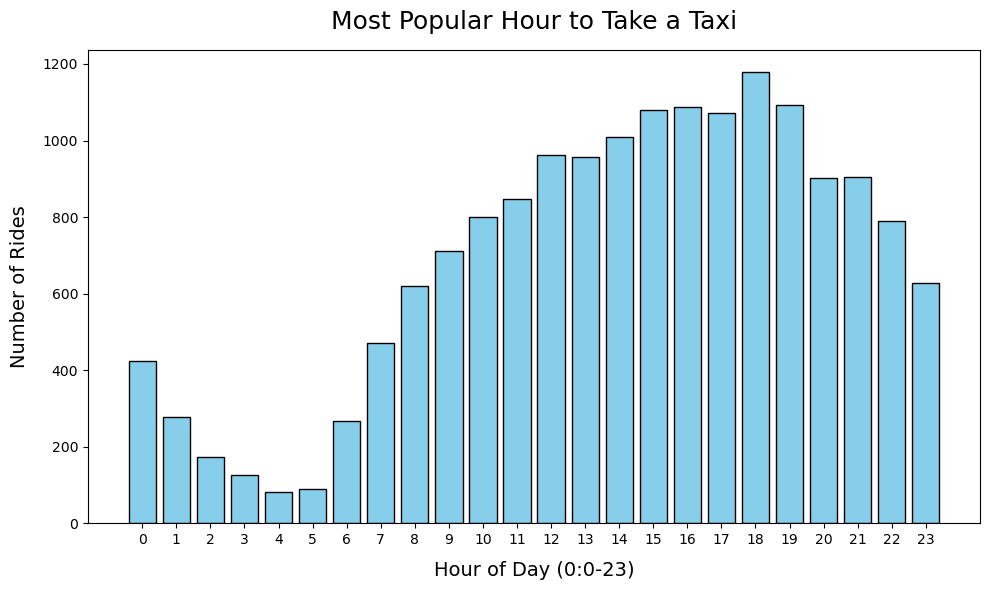

In [83]:
visual1_dataframe = get_data_for_visual_1()
plot_visual_1(visual1_dataframe)

### Visualization 2

**Q**: What’s the most popular month to hire a cab or Uber?<br>
**A**: The most popular month would be August. Starting from July to September, the travel demand would greatly increase as summer vacations begin and pushes the higher needs of transportation. 

In [195]:
#define sqrt in SQLite
DATABASE_URL = "/Users/liuhangjia/IEOR Tool For Analytic Files/Final_Project_Dataset/database"
#DATABASE_URL = "C:/Final_Project_Dataset/database"
conn = sqlite3.connect(DATABASE_URL+"/my_database.db")
#conn.create_function('sqrt', 1, math.sqrt)

In [77]:
def get_data_for_visual_2() -> pd.DataFrame:
    """
    Query the dataset to calculate and display average travel distances per month in regardless of years with 90% confident interval

    Returns:
        pd.DateFrame contains the following variables:
        Month = The numerical month from Jan to Dec
        mean = average distanced traveled
        count = number of trips listed
        lower = represents the lower bound of the confident interval
        upper = represents the upper bound of the confident interval
    """
    QUERY = """
    WITH combined_trips AS (
        SELECT 
            strftime('%m', tpep_pickup_datetime) AS month,
            trip_distance
        FROM taxi_trips
        WHERE DATE(tpep_pickup_datetime) BETWEEN '2020-01-01' AND '2024-08-31'
        UNION ALL
        SELECT 
            strftime('%m', pickup_datetime) AS month,
            trip_miles AS trip_distance
        FROM uber_trips
        WHERE DATE(pickup_datetime) BETWEEN '2020-01-01' AND '2024-08-31'
    ),
    mean_values AS (
        SELECT 
            CAST(month AS INTEGER) AS month_num,
            AVG(trip_distance) AS mean_distance
        FROM combined_trips
        GROUP BY month
    ),
    variance_calculation AS (
        SELECT 
            CAST(month AS INTEGER) AS month_num,
            AVG(trip_distance) AS mean_distance,
            COUNT(trip_distance) AS ride_count,
            SUM((trip_distance - (SELECT mean_distance FROM mean_values WHERE month_num = CAST(month AS INTEGER))) * 
                (trip_distance - (SELECT mean_distance FROM mean_values WHERE month_num = CAST(month AS INTEGER)))) 
                / (COUNT(trip_distance) - 1) AS variance
        FROM combined_trips
        GROUP BY month
    )
    SELECT 
        month_num,
        mean_distance,
        mean_distance - (1.645 * (sqrt(variance) / sqrt(ride_count))) AS lower_bound,
        mean_distance + (1.645 * (sqrt(variance) / sqrt(ride_count))) AS upper_bound
    FROM variance_calculation
    ORDER BY month_num
    """
    with engine:
        results = engine.execute(QUERY).fetchall()
    return pd.DataFrame(results, columns=['month', 'mean','lower', 'upper'])

# Fetch and visualize the data
def plot_visual_2(dataframe: pd.DataFrame) -> None:
    """
    Uses a line chart with a 90% confidence interval to visualize the average distance traveled per month.

    Parameters:
        dataframe (pd.DataFrame): A pandas DataFrame containing the 'month', 'mean', 'lower', and 'upper' columns.
    """
    months = dataframe['month']
    avg_distances = dataframe['mean']
    lower = dataframe['lower']
    upper = dataframe['upper']

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(months, avg_distances, marker="o", linestyle="-", color="skyblue", label="Average Distance")
    ax.fill_between(months, lower, upper, color="skyblue", alpha=0.2, label="90% Confidence Interval")

    ax.set_title("Average Distance Traveled Per Month (2020-2024)", fontsize=18, pad=15)
    ax.set_xlabel("Month (1 = January, ..., 12 = December)", fontsize=14, labelpad=10)
    ax.set_ylabel("Average Distance (Miles)", fontsize=14, labelpad=10)
    ax.set_xticks(range(1, 13)) 
    ax.legend()

    plt.tight_layout()
    plt.show()


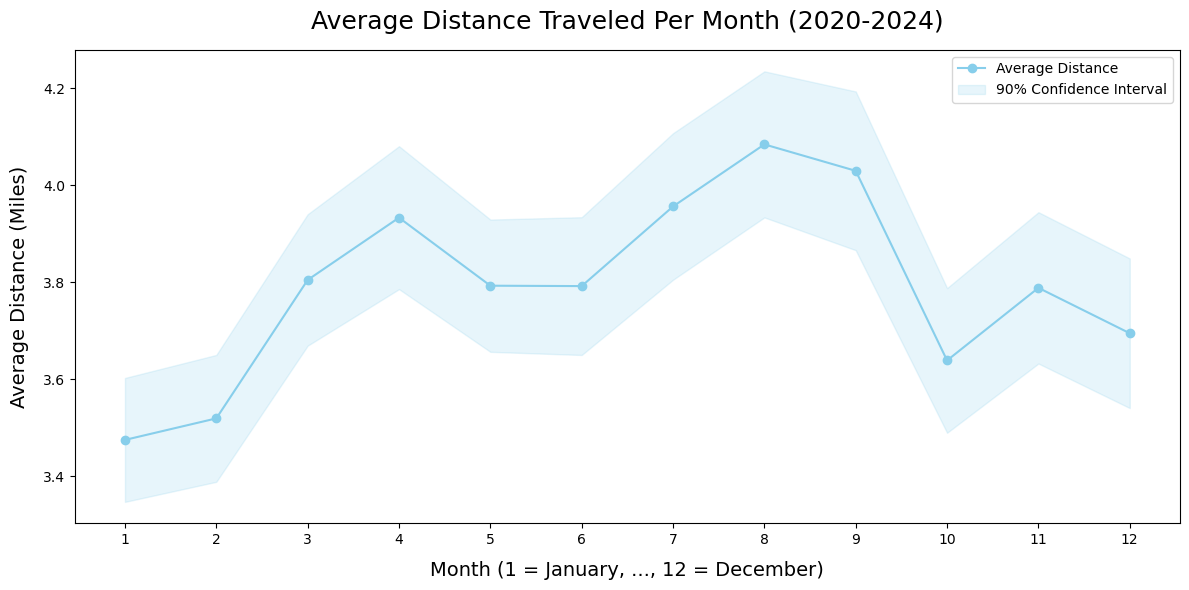

In [79]:
visual2_data = get_data_for_visual_2()
plot_visual_2(visual2_data)

### Visualization 3

**Q**: Which day of the week is most popular for taking a ride to an NYC-based airport<br>
**A**: On Thursday and Friday, which are the days closer to the weekends, they have the highest rides taken to NYC-based airport 

In [73]:
def get_data_for_visual_3() -> pd.DataFrame:
    """
    Fetches ride counts to NYC airports grouped by day of the week.

    Function:
    1. Limites the latitude and longtitude for both Taxi and Uber dataset
    2. Filters out the numbers of trips that has a dropoff location in the range of three different airport
    3. Converts the numerical representation of weeks into name format
    
    Returns:
        A DataFrame containing:
            day_of_week (str): The name of the day of the week 
            airport (str): The airport code (LGA, JFK, EWR)
            ride_count (int): The number of rides for each airport 
    """
    
    QUERY = """
    WITH taxi_rides_to_airports AS (
        SELECT 
            strftime('%w', tpep_pickup_datetime) AS day_of_week,
            CASE
                WHEN DO_latitude BETWEEN 40.763589 AND 40.778865 
                     AND DO_longitude BETWEEN -73.891745 AND -73.854838 THEN 'LGA'
                WHEN DO_latitude BETWEEN 40.639263 AND 40.651376 
                     AND DO_longitude BETWEEN -73.795642 AND -73.766264 THEN 'JFK'
                WHEN DO_latitude BETWEEN 40.686794 AND 40.699680 
                     AND DO_longitude BETWEEN -74.194028 AND -74.165205 THEN 'EWR'
                ELSE NULL
            END AS airport
        FROM taxi_trips
        WHERE airport IS NOT NULL
    ),
    uber_rides_to_airports AS (
        SELECT 
            strftime('%w', pickup_datetime) AS day_of_week,
            CASE
                WHEN DO_latitude BETWEEN 40.766 AND 40.790 
                     AND DO_longitude BETWEEN -73.890 AND -73.860 THEN 'LGA'
                WHEN DO_latitude BETWEEN 40.641 AND 40.662 
                     AND DO_longitude BETWEEN -73.790 AND -73.750 THEN 'JFK'
                WHEN DO_latitude BETWEEN 40.689 AND 40.709 
                     AND DO_longitude BETWEEN -74.190 AND -74.170 THEN 'EWR'
            END AS airport
        FROM uber_trips
        WHERE airport IS NOT NULL
    ),
    combined_rides AS (
        SELECT * FROM taxi_rides_to_airports
        UNION ALL
        SELECT * FROM uber_rides_to_airports
    ),
    grouped_rides AS (
        SELECT 
            day_of_week,
            airport,
            COUNT(*) AS ride_count
        FROM combined_rides
        GROUP BY day_of_week, airport
    )
    SELECT 
        CASE day_of_week
            WHEN '0' THEN 'Sunday'
            WHEN '1' THEN 'Monday'
            WHEN '2' THEN 'Tuesday'
            WHEN '3' THEN 'Wednesday'
            WHEN '4' THEN 'Thursday'
            WHEN '5' THEN 'Friday'
            WHEN '6' THEN 'Saturday'
        END AS day_of_week,
        airport,
        ride_count
    FROM grouped_rides
    ORDER BY day_of_week, airport
    """
    with engine:
        results = engine.execute(QUERY).fetchall()
    return pd.DataFrame(results, columns=['day_of_week', 'airport', 'ride_count'])


def plot_visual_3(dataframe: pd.DataFrame) -> None:
    """
    Uses a stacked bar chart to show the number of rides to NYC airports by day of the week

    Parameters:
        dataframe (pd.DataFrame): A DataFrame containing columns for "day_of_week", "airport", and "ride_count"

    """
    days = dataframe['day_of_week'].unique()
    airports = dataframe['airport'].unique()
    
    grouped = dataframe.pivot(index='day_of_week', columns='airport', values='ride_count').fillna(0)
    grouped = grouped.reindex(['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])

    #Choose three different type of blue
    blue_shades = ['#ADD8E6', '#87CEEB', '#4682B4']
    
    grouped.plot(kind='bar', stacked=True, figsize=(12, 6),color=blue_shades)
    plt.title("Rides to NYC Airports by Day of the Week", fontsize=18, pad=15)
    plt.xlabel("Day of the Week", fontsize=14, labelpad=10)
    plt.ylabel("Number of Rides", fontsize=14, labelpad=10)
    plt.xticks(rotation=0)  
    plt.legend(title="Airport", fontsize=12)
    plt.tight_layout()
    plt.show()

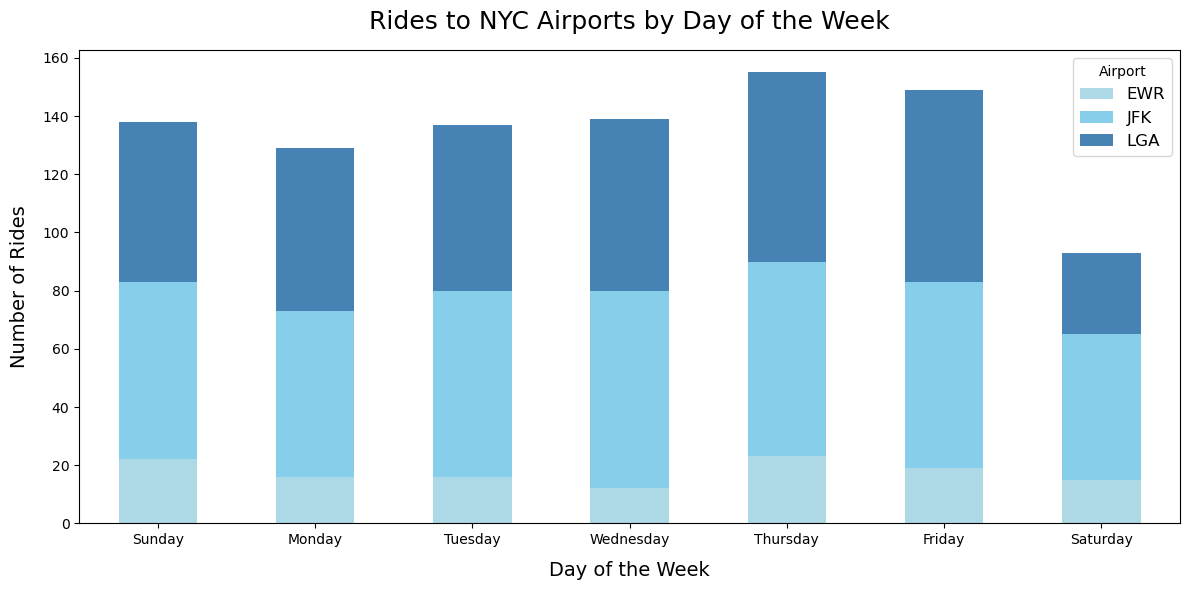

In [75]:
visual3_data = get_data_for_visual_3()
plot_visual_3(visual3_data)

### Visualization 4 ###

**Q:** How much do hired rides earn in total fares monthly<br>
**A:** As shown in the graph below, Taxi generally has higher total fares monthly than uber.

In [124]:
DATABASE_URL = "/Users/liuhangjia/IEOR Tool For Analytic Files/Final_Project_Dataset/database"
#DATABASE_URL = "C:/Final_Project_Dataset/database"
conn = sqlite3.connect(DATABASE_URL+"/my_database.db")

# Define the SQL query
query_taxi = "SELECT * FROM taxi_trips"
query_uber = "SELECT * FROM uber_trips"

# Load data into a Pandas DataFrame
taxi_df = pd.read_sql_query(query_taxi, conn)
uber_df = pd.read_sql_query(query_uber, conn)

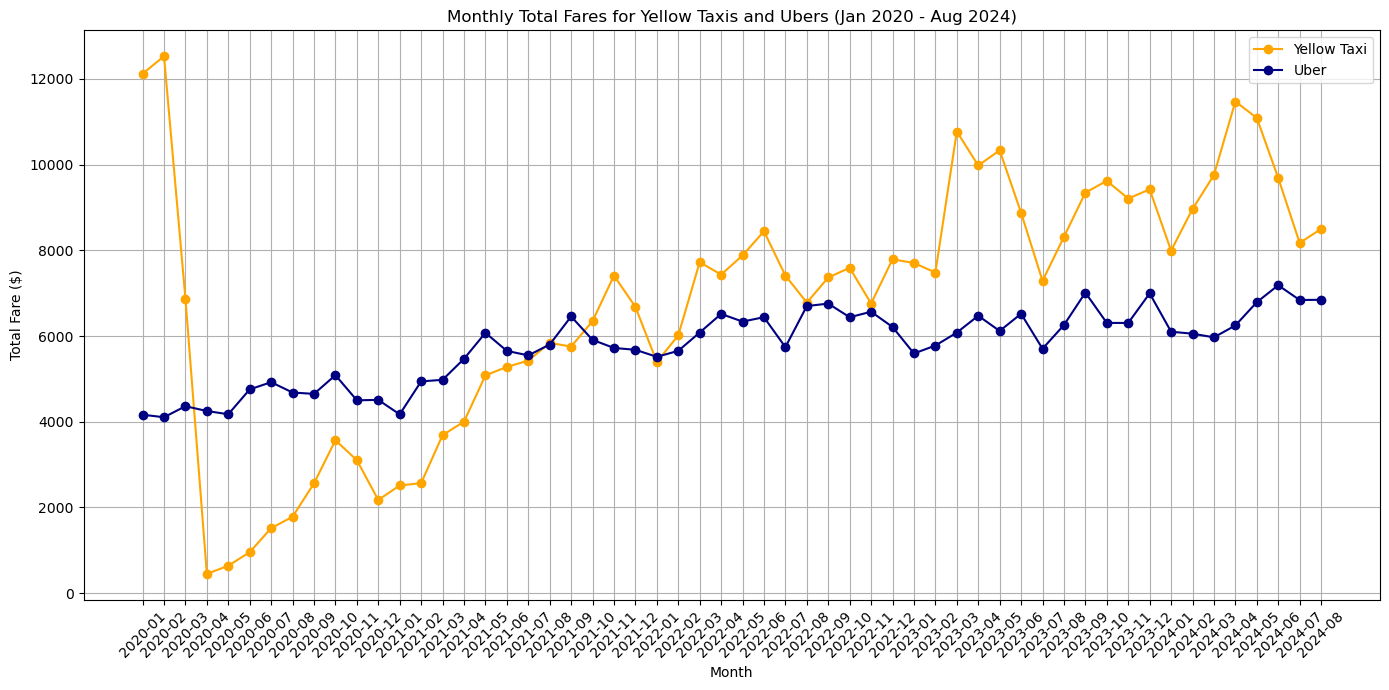

In [126]:
# Convert datetime columns to datetime objects
taxi_df['tpep_pickup_datetime'] = pd.to_datetime(taxi_df['tpep_pickup_datetime'])
uber_df['pickup_datetime'] = pd.to_datetime(uber_df['pickup_datetime'])

# Replace NaN values with 0
taxi_df.fillna(0, inplace=True)
uber_df.fillna(0, inplace=True)

# Filter data between January 2020 and August 2024
start_date = '2020-01-01'
end_date = '2024-08-31'

taxi_df = taxi_df[(taxi_df['tpep_pickup_datetime'] >= start_date) & (taxi_df['tpep_pickup_datetime'] <= end_date)]
uber_df = uber_df[(uber_df['pickup_datetime'] >= start_date) & (uber_df['pickup_datetime'] <= end_date)]

# Calculate total fare for taxi rides
taxi_df['total_fare'] = (taxi_df['fare_amount'] +
                         taxi_df['extra'] +
                         taxi_df['mta_tax'] +
                         taxi_df['tip_amount'] +
                         taxi_df['tolls_amount'] +
                         taxi_df['improvement_surcharge'] +
                         taxi_df['congestion_surcharge'])

# Calculate total fare for uber rides
uber_df['total_fare'] = (uber_df['base_passenger_fare'] +
                         uber_df['tolls'] +
                         uber_df['sales_tax'] +
                         uber_df['congestion_surcharge'] +
                         uber_df['airport_fee'] +
                         uber_df['tips'])

# Create a 'month' column for grouping
taxi_df['month'] = taxi_df['tpep_pickup_datetime'].dt.to_period('M')
uber_df['month'] = uber_df['pickup_datetime'].dt.to_period('M')

# Group by month and calculate total fares
taxi_monthly_fares = taxi_df.groupby('month')['total_fare'].sum().reset_index()
uber_monthly_fares = uber_df.groupby('month')['total_fare'].sum().reset_index()

# Merge the two DataFrames
combined_fares = pd.merge(taxi_monthly_fares, uber_monthly_fares, on='month', suffixes=('_taxi', '_uber'))

# Plot the data
plt.figure(figsize=(14, 7))

plt.plot(combined_fares['month'].astype(str), combined_fares['total_fare_taxi'], label='Yellow Taxi', marker='o', color = 'orange')
plt.plot(combined_fares['month'].astype(str), combined_fares['total_fare_uber'], label='Uber', marker='o',color = 'navy')

plt.xticks(rotation=45)
plt.xlabel('Month')
plt.ylabel('Total Fare ($)')
plt.title('Monthly Total Fares for Yellow Taxis and Ubers (Jan 2020 - Aug 2024)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Visualization 5 ###

**Q:** Does precipitation or distance traveled affect the amount of tip?`

In [134]:
DATABASE_URL = "/Users/liuhangjia/IEOR Tool For Analytic Files/Final_Project_Dataset/database"
#DATABASE_URL = "C:/Final_Project_Dataset/database"
conn = sqlite3.connect(DATABASE_URL+"/my_database.db")

# Define the SQL query
query_weather_hourly = "SELECT * FROM hourly_weather"

# Load data into a Pandas DataFrame
weather_hourly_df = pd.read_sql_query(query_weather_hourly, conn)

In [136]:
print(weather_hourly_df.columns.to_list())

['STATION', 'DATE', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'NAME', 'REPORT_TYPE', 'SOURCE', 'HourlyAltimeterSetting', 'HourlyDewPointTemperature', 'HourlyDryBulbTemperature', 'HourlyPrecipitation', 'HourlyPresentWeatherType', 'HourlyPressureChange', 'HourlyPressureTendency', 'HourlyRelativeHumidity', 'HourlySkyConditions', 'HourlySeaLevelPressure', 'HourlyStationPressure', 'HourlyVisibility', 'HourlyWetBulbTemperature', 'HourlyWindDirection', 'HourlyWindGustSpeed', 'HourlyWindSpeed', 'REM', 'BackupElements', 'BackupEquipment', 'BackupName', 'WindEquipmentChangeDate']


In [153]:
# Function to clean the precipitation values
weather_hourly_df.fillna(0, inplace=True)
def clean_precipitation(value: str) -> float:
    """
    Cleans and standardizes precipitation values.

    Parameters:
        value (str): The precipitation value changed from str to output float

    Returns:
        float: The cleaned precipitation value.
    """
    if isinstance(value, str):
        if value == 'T':
            return 0.01
        elif value.endswith('s'):
            return float(value[:-1])
    return float(value)

# Apply the cleaning function to the 'HourlyPrecipitation' column
weather_hourly_df['HourlyPrecipitation'] = weather_hourly_df['HourlyPrecipitation'].apply(clean_precipitation)

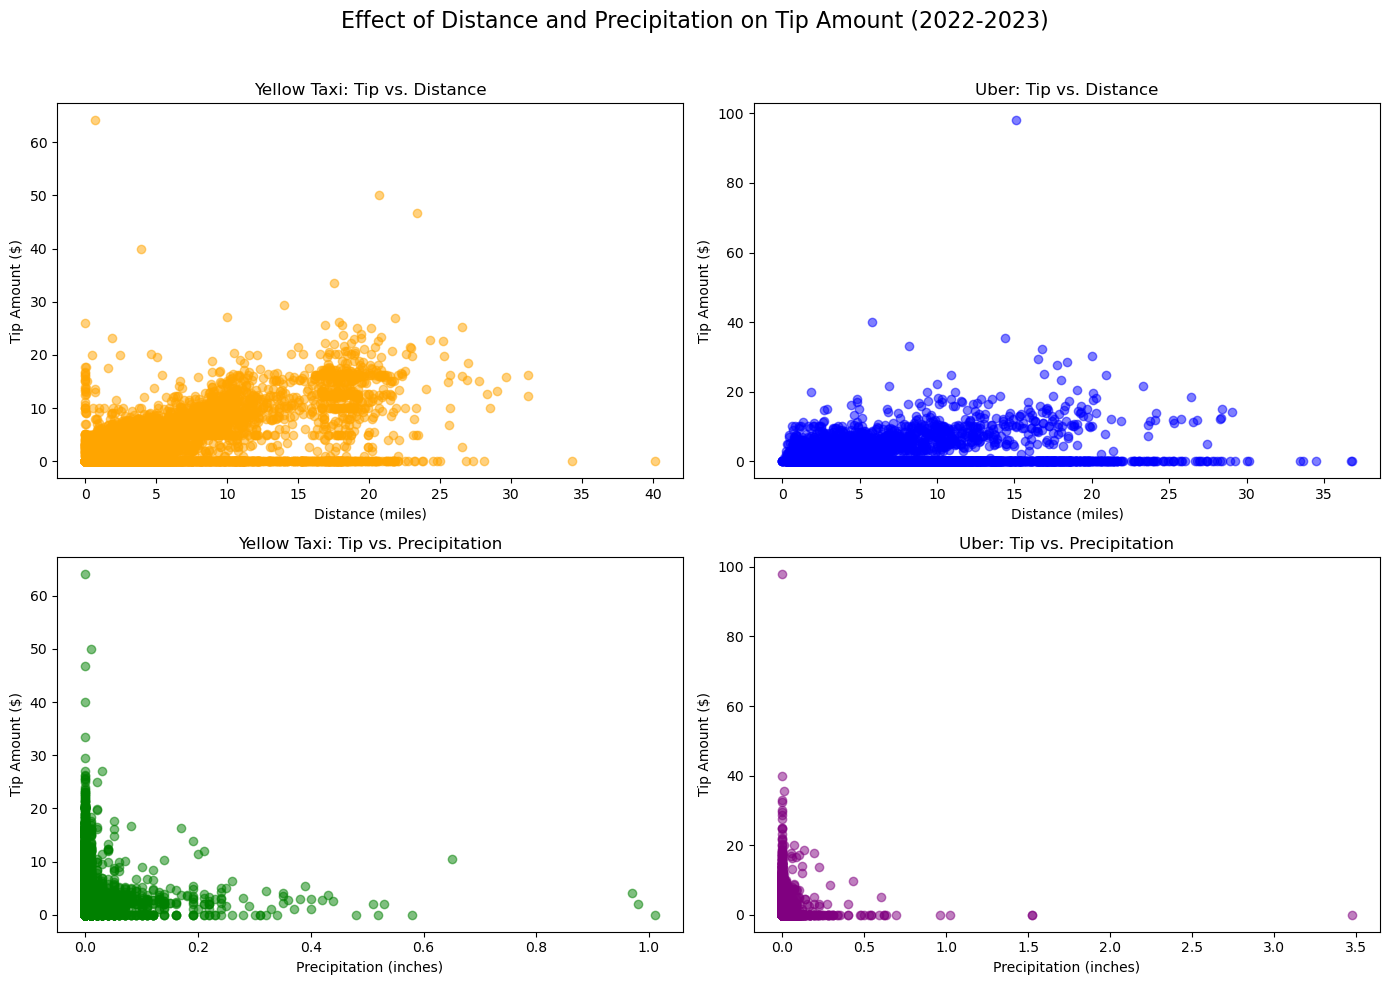

In [140]:
# Ensure DATE is in datetime format
weather_hourly_df['DATE'] = pd.to_datetime(weather_hourly_df['DATE'])
taxi_df['tpep_pickup_datetime'] = pd.to_datetime(taxi_df['tpep_pickup_datetime'])
uber_df['pickup_datetime'] = pd.to_datetime(uber_df['pickup_datetime'])

# Merge weather data with taxi_df based on the closest hour
taxi_df = pd.merge_asof(
    taxi_df.sort_values('tpep_pickup_datetime'),
    weather_hourly_df.sort_values('DATE'),
    left_on='tpep_pickup_datetime',
    right_on='DATE'
)

# Merge weather data with uber_df based on the closest hour
uber_df = pd.merge_asof(
    uber_df.sort_values('pickup_datetime'),
    weather_hourly_df.sort_values('DATE'),
    left_on='pickup_datetime',
    right_on='DATE'
)

# Create a 2x2 plot grid for scatter plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Effect of Distance and Precipitation on Tip Amount (2022-2023)', fontsize=16)

# Scatter plot 1: Tip vs. Distance for Yellow Taxis
axes[0, 0].scatter(taxi_df['trip_distance'], taxi_df['tip_amount'], alpha=0.5, color='orange')
axes[0, 0].set_title('Yellow Taxi: Tip vs. Distance')
axes[0, 0].set_xlabel('Distance (miles)')
axes[0, 0].set_ylabel('Tip Amount ($)')

# Scatter plot 2: Tip vs. Distance for Uber Rides
axes[0, 1].scatter(uber_df['trip_miles'], uber_df['tips'], alpha=0.5, color='blue')
axes[0, 1].set_title('Uber: Tip vs. Distance')
axes[0, 1].set_xlabel('Distance (miles)')
axes[0, 1].set_ylabel('Tip Amount ($)')

# Scatter plot 3: Tip vs. Precipitation for Yellow Taxis
axes[1, 0].scatter(taxi_df['HourlyPrecipitation'], taxi_df['tip_amount'], alpha=0.5, color='green')
axes[1, 0].set_title('Yellow Taxi: Tip vs. Precipitation')
axes[1, 0].set_xlabel('Precipitation (inches)')
axes[1, 0].set_ylabel('Tip Amount ($)')

# Scatter plot 4: Tip vs. Precipitation for Uber Rides
axes[1, 1].scatter(uber_df['HourlyPrecipitation'], uber_df['tips'], alpha=0.5, color='purple')
axes[1, 1].set_title('Uber: Tip vs. Precipitation')
axes[1, 1].set_xlabel('Precipitation (inches)')
axes[1, 1].set_ylabel('Tip Amount ($)')

# Improve layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### Visualization 6 ###

Heatmap of all hired trips in 2020 over a map of the area.

In [151]:
import matplotlib.pyplot as plt
import seaborn as sns
# Filter taxi_df and uber_df for trips in 2020
taxi_2020 = taxi_df[taxi_df['tpep_pickup_datetime'].dt.year == 2020]
uber_2020 = uber_df[uber_df['pickup_datetime'].dt.year == 2020]

# Combine pickup coordinates from both datasets
pickup_coords = pd.concat([
    taxi_2020[['PU_latitude', 'PU_longitude']].rename(columns={'PU_latitude': 'latitude', 'PU_longitude': 'longitude'}),
    uber_2020[['PU_latitude', 'PU_longitude']].rename(columns={'PU_latitude': 'latitude', 'PU_longitude': 'longitude'})
], ignore_index=True)

# Calculate the mean latitude and longitude to center the map
mean_lat = pickup_coords['latitude'].mean()
mean_lon = pickup_coords['longitude'].mean()

# Initialize the Folium map centered around the mean coordinates
m = folium.Map(location=[mean_lat, mean_lon], zoom_start=11)

# Prepare data for the heatmap
heat_data = [[row['latitude'], row['longitude']] for _, row in pickup_coords.iterrows()]

# Add the heatmap layer to the map
HeatMap(heat_data, radius=8).add_to(m)

# Display the map in a Jupyter Notebook
m